<a href="https://colab.research.google.com/github/estebanhernandezr/Entregas-Semanales/blob/main/Copia_de_Vowels_Classifier_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Link de la base de datos** de las notas de voz de las vocales: https://drive.google.com/drive/folders/1IT7fPIILV31XG_mjizrrhWzDIFN2pKA-?usp=sharing

Puede que para acceder a la notas de voz en drive tenga que:

*   Hacer **Click Derecho** sobre la carpeta (a la que redirige el link)
*   Seleccionar la opción **añadir acceso directo al Drive**




#**Imports and GitHub**

In [70]:
!pip install pydub

In [71]:
from keras.datasets import mnist
import numpy as np
import os
from google.colab import drive
import sys
from scipy.io import wavfile
import scipy.io
import matplotlib.pyplot as plt
from pydub import AudioSegment
import wave
import traceback
from logging import exception
from scipy.signal import welch
import pandas as pd
from keras import models
from keras import layers
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Importación de los datos**

# NOTA: si se va a correr el código completamente desde el inicio, después de ejecutar las líneas de código de abajo se tiene que añadir el archivo de audio a la carpeta Test. En caso de que se añadan desde antes los archivos, se tiene que hacer en una carpeta "Test" y se comentan las líneas.

In [ ]:
route = "Test/"
os.mkdir(route)

Para empezar, debemos cargar la base de datos desde *google drive*. Para esto, utilizamos el modulo **drive**. Una vez realizada la interfaz desde *colab*, navegamos entre las carpetas hasta la ruta: ***content/drive/My Drive/Proyecto Clasificación de Vocales)***.

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


A continuación, accedemos al contenido de la ruta. Nos percatamos de que en ella existen tres carpetas: **A**, **E**, **I**, **O** Y **U**, cada una de las cuales contiene una colección de notas de voz de *Whatsapp* (archivos **.ogg**) convertidos a archivos **.wav**. Estos archivos corresponden a una muestra aleatoria tomada por los estudiantes del curso de *Aprendizaje Automático de Máquina*, compuesta en su mayoría por voces de jovenes adultos (compañeros de **MACC**).

In [ ]:
!ls "/content/drive/My Drive/Proyecto Clasificación de Vocales"

A  convert.ipynb  E  I	O  U  Untitled0.ipynb


Antes de continuar, por si acaso, reescribimos los archivos en una **ruta local** como archivos con extensión **.wav**. Para esto utilizamos el módulo *pydub*.

In [ ]:
path = "/content/drive/My Drive/Proyecto Clasificación de Vocales/"
route = "WAVs/"
os.mkdir(route)
vocales = ['A', 'E', 'I', 'O', 'U']
for vocal in vocales:
     os.mkdir(route+vocal)
     for audio in os.listdir(path+vocal):
         audio_seg = AudioSegment.from_ogg(path+vocal+'/'+audio)
         wav_file = audio_seg.export(route+vocal+'/'+audio, format="wav")
         #open(route+vocal+'/'+audio, 'w')
         #wave.open(route+vocal+'/'+audio,'wb')

FileExistsError: ignored

Accediendo al contenido de la carpeta **A**

In [ ]:
#path_A = '/content/drive/My Drive/Proyecto Clasificación de Vocales/A'
path_A = '/content/WAVs/A'
dir_path_A = os.path.dirname(os.path.realpath(path_A))
A_records = []
for root, dirs, files in os.walk(dir_path_A):
    for record in files:
        if record.startswith('A') and record.endswith('.wav'):
            A_records.append(record)

Accediendo al contenido de la carpeta **E**

In [ ]:
#path_E = '/content/drive/My Drive/Proyecto Clasificación de Vocales/E'
path_E = '/content/WAVs/E'
dir_path_E = os.path.dirname(os.path.realpath(path_E))
E_records = []
for root, dirs, files in os.walk(dir_path_E):
    for record in files:
        if record.startswith('E') and record.endswith('.wav'):
            E_records.append(record)

Accediendo al contenido de la carpeta **I**

In [ ]:
#path_I = '/content/drive/My Drive/Proyecto Clasificación de Vocales/I'
path_I = '/content/WAVs/I'
dir_path_I = os.path.dirname(os.path.realpath(path_I))
I_records = []
for root, dirs, files in os.walk(dir_path_I):
    for record in files:
        if record.startswith('I') and record.endswith('.wav'):
            I_records.append(record)

Accediendo al contenido de la carpeta **O**

In [ ]:
#path_O = '/content/drive/My Drive/Proyecto Clasificación de Vocales/O'
path_O = '/content/WAVs/O'
dir_path_O = os.path.dirname(os.path.realpath(path_O))
O_records = []
for root, dirs, files in os.walk(dir_path_O):
    for record in files:
        if record.startswith('O') and record.endswith('.wav'):
            O_records.append(record)

Accediendo al contenido de la carpeta **U**

In [ ]:
#path_U = '/content/drive/My Drive/Proyecto Clasificación de Vocales/U'
path_U = '/content/WAVs/U'
dir_path_U = os.path.dirname(os.path.realpath(path_U))
U_records = []
for root, dirs, files in os.walk(dir_path_U):
    for record in files:
        if record.startswith('U') and record.endswith('.wav'):
            U_records.append(record)

#**Visualización de los datos**

A continuación imprimimos los archivos de la ruta, separados por clases en diferentes vectores y sus respectivas longitudes. Deberiamos ser capaces de ver únicamente archivos con extensión **.wav**. Para empezar, notaremos que existen al rededor de 100 archivos por cada vocal: la manera en la que se construyo la muestra; a cada persona se le pidio pronunciar las 5 vocales, ayuda a garantizar una cantidad similar para todos las vocales.

Con todo lo que hemos hecho hasta ahora ya podemos acceder las notas de voz. Así que, ya podemos comenzar a visualizar los datos importados.

Es importante tener en cuenta que los archivos con los que estamos trabajando son archivos **.wav**, en ese orden de ideas, conviene tener claro qué tipo de información un archivo **.wav** es capaz de proveer acerca de la señal.

In [ ]:
def visualize_wav_meta(path, wav_file):
    samplerate, data = wavfile.read(path+'/'+wav_file)
    if (isinstance(data[0], np.ndarray)):
        print(f"number of frames = {data.shape[0]}")
        print(f"number of channels = {data.shape[1]}")
    else:
        print(f"number of frames = {len(data)}")
        print(f"number of channels = {1}")

def visualize_wav_wave(path, wav_file):
    samplerate, data = wavfile.read(path+'/'+wav_file)
    if (isinstance(data[0], np.ndarray)):
        length = data.shape[0] / samplerate    
        time = np.linspace(0., length, data.shape[0])
        plt.plot(time, data[:, 0], label="Left channel")
        plt.plot(time, data[:, 1], label="Right channel")
        plt.legend()
        plt.title(wav_file)
        plt.xlabel("Time [seg]")
        plt.ylabel("Amplitude")
        plt.show()
        plt.psd(data[:, 1], samplerate)
        plt.show()
    else:
        length = len(data) / samplerate
        time = np.linspace(0., length, len(data))
        plt.plot(time, data, label="Only channel")
        plt.legend()
        plt.title(wav_file)
        plt.xlabel("Time [seg]")
        plt.ylabel("Amplitude")
        plt.show()
        plt.psd(data, samplerate)
        plt.show()
    print("Duración: ", length)

def visualize_wav_info(path, wav_file):
    try:
        visualize_wav_meta(path, wav_file)
        visualize_wav_wave(path, wav_file)
    except Exception as e:
        print(e)

A continuación visualizamos alguna de la información que es posible extraer de los archivos **.wav** con python: características descriptivas de los archivos y una gráfica de la onda de sonido. Además de esto último, también graficamos el espectro *PSD* (*Power Spectral Density*) en función de la *frecuencia* de la señal. Para generar ambas gráficas utilizamos los modulos **scipy** y **matplotlib**. Mientras que, para obtener la información utilizamos el modulo **scipy.wavfile**, especificamente, la función **read**.

Visualizamos la información para cada una de las muestras de las clases **A**, **E**, **I**, **O** y **U**.

In [ ]:
for a in A_records:
    visualize_wav_info(path_A, a)

Podemos notar algunas cosas que son importantes tener en cuenta:


1.   Algunas muestras de sonido corresponden a un **sonido estereo**, es decir, son una sucesión de valores para un altavoz izquierdo, y otro derecho. Pero, en realidad, solamente los registros del altavoz izquierdo son significativos, pues en el estereograma del canal derecho parece no existir. Esto puede detectarse facilmente en la información del archivo por medio de **shape**, ya que los sonidos estereos se caracterizan por **shape = (x, 2)**, mientras que los **mono auditivos** se caracterizan por **shape = (x,   )**. Esto también puede deducirse facilmente de los colores de las gráficas: cuando se trata de un **sonido estereo** hay dos curvas (azul y naranja), cuando no, solo una (azul).

2.   Las señales de sonido **no** están normalizadas.

3.   Visualmente, las señales de diferentes clases pueden parecerse mucho entre sí.

4.   No existe la misma cantidad de sonidos **estereo** que de sonidos **mono auditivos**.





In [ ]:
def visualize_all_wave(path, wav_file):
    samplerate, data = wavfile.read(path+'/'+wav_file)
    if (isinstance(data[0], np.ndarray)):
        length = data.shape[0] / samplerate    
        time = np.linspace(0., length, data.shape[0])
        """plt.plot(time, data[:, 0], label="Left channel")
        plt.plot(time, data[:, 1], label="Right channel")
        plt.legend()
        plt.title(wav_file)
        plt.xlabel("Time [seg]")
        plt.ylabel("Amplitude")
        plt.show()"""
        plt.psd(data[:, 1], 2**5, scale_by_freq=True)
        #plt.show()
    else:
        length = len(data) / samplerate
        time = np.linspace(0., length, len(data))
        """plt.plot(time, data, label="Only channel")
        plt.legend()
        plt.title(wav_file)
        plt.xlabel("Time [seg]")
        plt.ylabel("Amplitude")
        plt.show()"""
        plt.psd(data, 2**5, scale_by_freq=True)
        #plt.show()
    print("Duración: ", length)

def visualize_all_psd(path, wav_file):
    try:
        #visualize_wav_meta(path, wav_file)
        visualize_wav_wave(path, wav_file)
    except Exception as e:
        print(e)

In [ ]:
for a in A_records:
    visualize_all_psd(path_A, a)

Ahora bien, de aquí no podemos sacar mucha información aún, es necesario realizar un preprocesamiento de los datos para aislar la onda del sonido e interpretarla de mejor manera. En siguiente método lo utilizaremos a continuación (en la siguiente sección) para llevar a cabo el preprocesamiento de los datos.

#**Preprocesamiento de los datos**

Heredamos algunas funcionalidades y gráficas de la sección anterior para poder visualizar cómo se está llevando a cabo el **preprocesamiento de los datos**:

La representación de la señal de audio que hicimos antes representa una señal de audio en el **dominio del tiempo**. Muestra la intensidad (volumen o amplitud) de la onda sonora con respecto al tiempo. Porciones con **amplitud = 0**, representan **silencio**.


In [ ]:
def visualize_wave(samplerate, data):
    if (isinstance(data[0], np.ndarray)):
        length = data.shape[0] / samplerate    
        time = np.linspace(0., length, data.shape[0])
        plt.plot(time, data[:, 0], label="Left channel")
        plt.plot(time, data[:, 1], label="Right channel")
        plt.legend()
        plt.xlabel("Time [seg]")
        plt.ylabel("Amplitude")
        plt.show()
        #plt.psd(data[:, 1], samplerate)
        #plt.show()
    else:
        length = len(data) / samplerate
        time = np.linspace(0., length, len(data))
        plt.plot(time, data, label="Only channel")
        plt.legend()
        plt.xlabel("Time [seg]")
        plt.ylabel("Amplitude")
        plt.show()
        #plt.psd(data, samplerate)
        #plt.show()
    print("Duración: ", length, "seg")

Ahora bien, como vimos anteriormente, los datos pueden presentar mucho **ruido** y tener **distintos volúmenes** para cada nota de voz, pero también **silencios** en los que los datos son insignificantes.

Notemos lo siguiente: podemos eliminar los trozos en los que no hay sonido, encontrando el **centro de masa del vector** y un **epsilon al rededor de ese centro de masa**. Asumimos que la vocal sucede cuando hay mayores amplitudes.

Así, podemos eliminar los trozos del audio en los que no hay sonido, tenemos la ventaja de que solamente habrá un único pico en el momento en que la persona pronuncia la vocal: el centro de masa es único.

In [ ]:
def remove_silences_signal(samplerate, data):
    centermass = 0
    mass = 0
    disperssion_eps_idx = 10000
    if (isinstance(data[0], np.ndarray)):
        for i in range(len(data)):
            centermass += abs(data[i, 1])*i
            mass += abs(data[i, 1])
        centermass_idx = int(centermass/mass)
    else:        
        for i in range(len(data)):
            centermass += abs(data[i])*i
            mass += abs(data[i])
        centermass_idx = int(centermass/mass)

    onda = data[centermass_idx-disperssion_eps_idx : centermass_idx+disperssion_eps_idx]
    return onda

Una vez que nos hemos deshecho de la mayor parte del ruido y silencios inútiles, el paso siguiente es **normalizar** los datos para garantizar que todas las notas de voz tienen una amplitud comparable, entre ellas. Para hacer esto, lo que hacemos es obtener el **promedio de la amplitud de la señal** y restarla a cada una de las muestras. Luego, dividimos entre el **máximo de la señal**. Así, centramos la señal al rededor de **cero** con una amplitud máxima de **uno**.

In [ ]:
def normalize_signal(samplerate, data):
    if (isinstance(data[0], np.ndarray)):
        data = data[:, 1]
    
    maxim = max(data)
    prom = 0
    for i in range(len(data)):
        prom += data[i]
    prom = prom/len(data)

    norm_data = []
    for i in range(len(data)):
        norm_data.append((data[i] - prom)/maxim)
    return norm_data

Por último, una vez hemos encontrado el centro de masa y normalizado el audio, aplicamos un último filtro a los datos: eliminamos aquellas porciones del audio que son insignicantes incluso en la señal normalizada. La idea es la siguiente: ya normalizados los datos son comparables las notas de voz entre sí, independientemente de su volumen (amplitud); no en vano, aquellas porciones del audio que sean aún demasiado pequeñas corresponderan a ruido y no a variaciones en el volumen de la señal.

In [ ]:
def cut_signal(samplerate, data):
    cutting = False
    i = 0
    if (isinstance(data[0], np.ndarray)):
        data = data[:, 1]
    while cutting == False:
        if abs(data[i]) >= 0.2:
            cutting = True
        else:
            i += 1
    length = len(data)/samplerate
    time = np.linspace(0., length, len(data))
    base_time = time[i]
    cut_data = []
    actual_time = []
    epoch = 0
    while epoch <= 0.2:
        cut_data.append(data[i])
        actual_time.append(time[i])
        epoch = actual_time[-1] - actual_time[0]
        #print(epoch)
        i += 1
    return cut_data

A continuación visualizamos los resultados del **preprocesamiento** de los datos: visualizamos las señales de audio **centradas**, **normalizadas** y **cortadas**.

A_006.wav


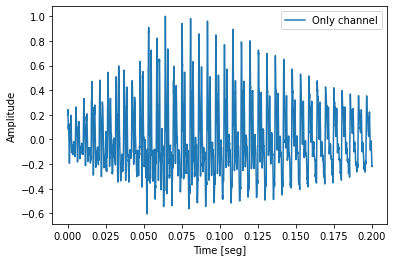

Duración:  0.20002083333333334 seg

A_052.wav


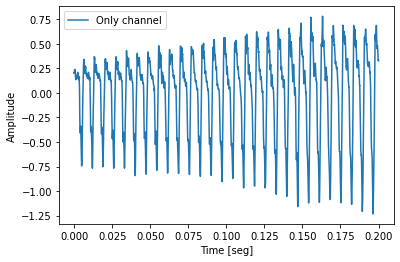

Duración:  0.20002083333333334 seg

A_077.wav


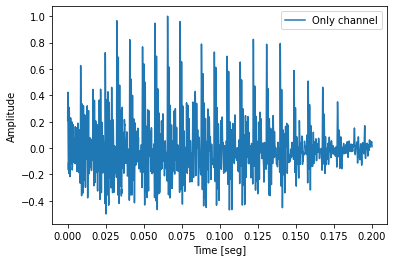

Duración:  0.20002083333333334 seg

A_054.wav


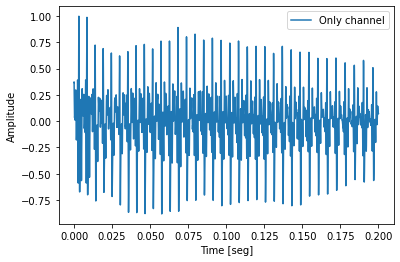

Duración:  0.20002083333333334 seg

A_061.wav


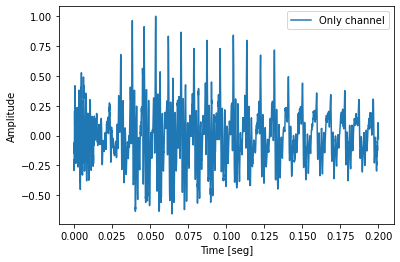

Duración:  0.20002083333333334 seg

A_028.wav


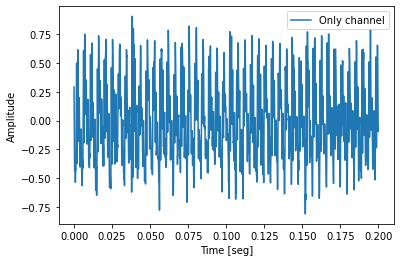

Duración:  0.20002083333333334 seg

A_042.wav


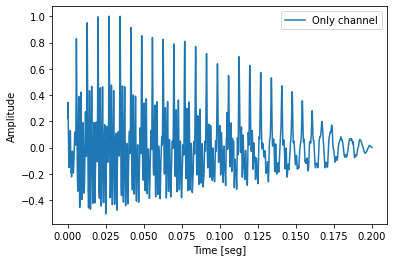

Duración:  0.20002083333333334 seg

A_99.wav


Duración:  0.20002083333333334 seg

A_060.wav


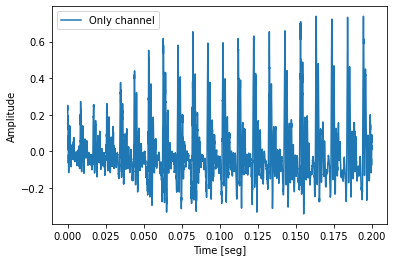

Duración:  0.20002083333333334 seg

A_022.wav


Duración:  0.20002083333333334 seg

A_033.wav


Duración:  0.20002083333333334 seg

A_011.wav


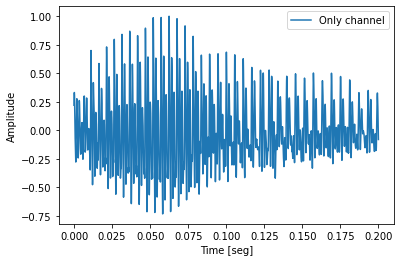

Duración:  0.20002083333333334 seg

A_082.wav


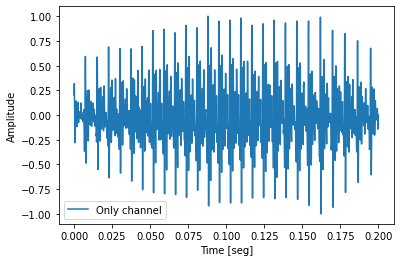

Duración:  0.20002083333333334 seg

A_057.wav


Duración:  0.20002083333333334 seg

A_063.wav


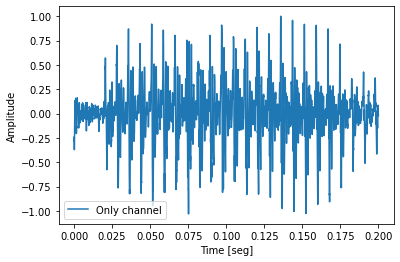

Duración:  0.20002083333333334 seg

A_026.wav


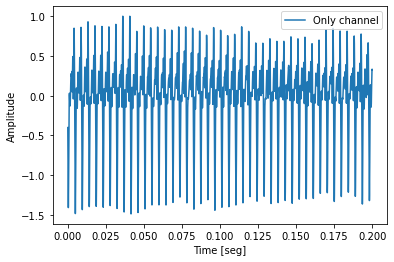

Duración:  0.20002083333333334 seg

A_032.wav


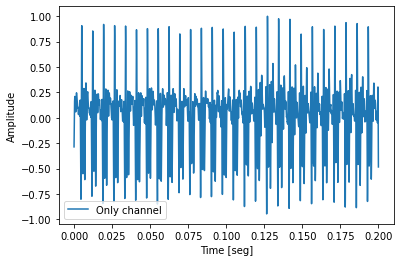

Duración:  0.20002083333333334 seg

A_96.wav


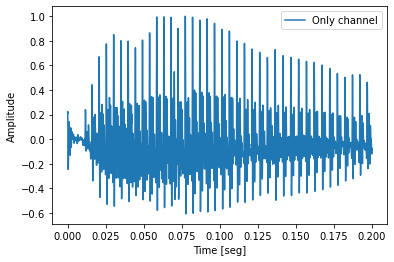

Duración:  0.20002083333333334 seg

A_100.wav


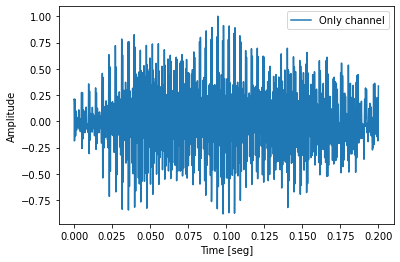

Duración:  0.20002083333333334 seg

A_043.wav


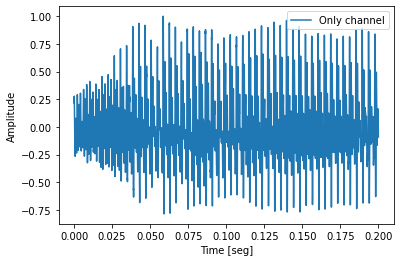

Duración:  0.20002083333333334 seg

A_027.wav


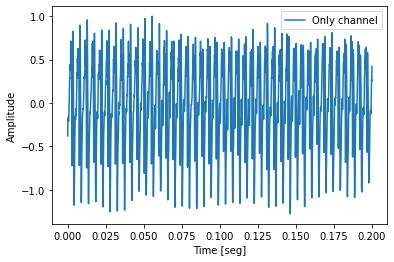

Duración:  0.20002083333333334 seg

A_065.wav


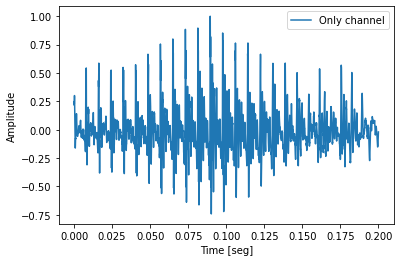

Duración:  0.20002083333333334 seg

A_003.wav


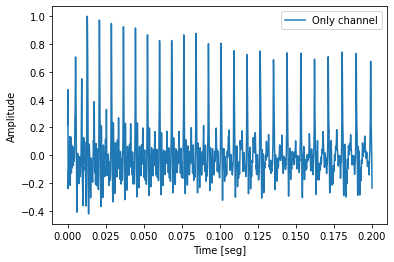

Duración:  0.20002083333333334 seg

A_002.wav


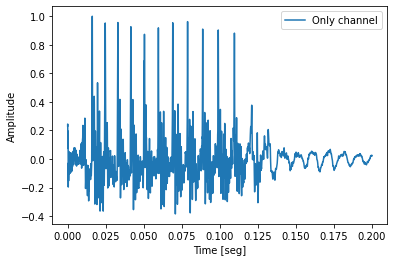

Duración:  0.20002083333333334 seg

A_92.wav


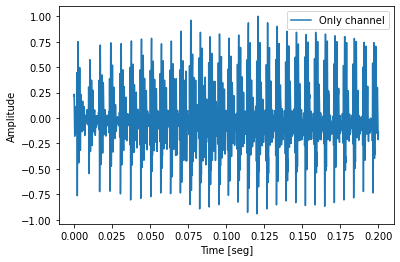

Duración:  0.20002083333333334 seg

A_079.wav


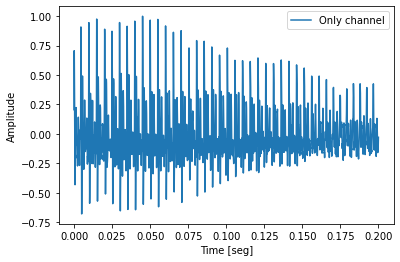

Duración:  0.20002083333333334 seg

A_045.wav


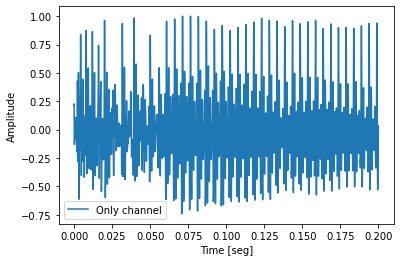

Duración:  0.20002083333333334 seg

A_030.wav


Duración:  0.20002083333333334 seg

A_053.wav


Duración:  0.20002083333333334 seg

A_062.wav


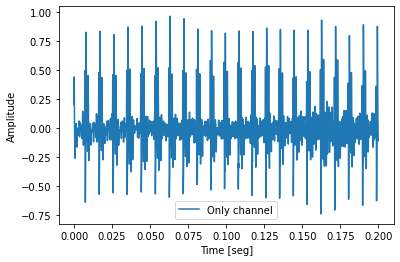

Duración:  0.20002083333333334 seg

A_046.wav


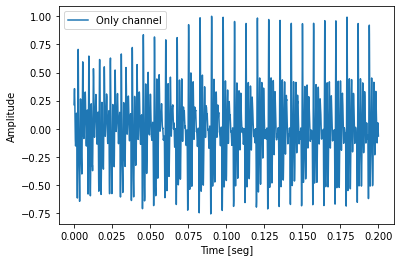

Duración:  0.20002083333333334 seg

A_009.wav


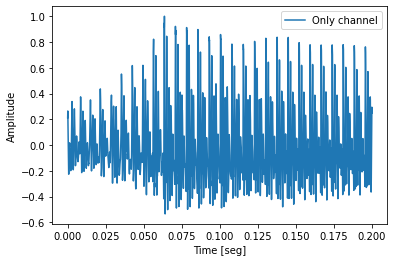

Duración:  0.20002083333333334 seg

A_93.wav


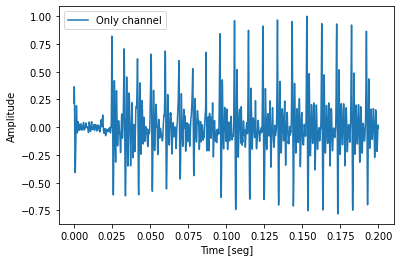

Duración:  0.20002083333333334 seg

A_031.wav


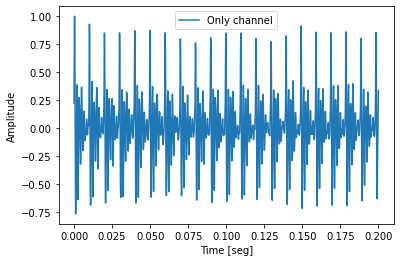

Duración:  0.20002083333333334 seg

A_017.wav


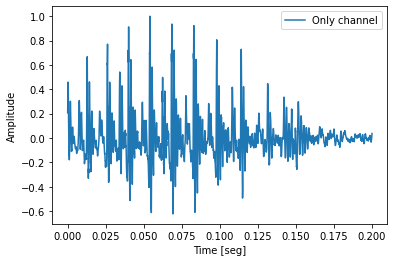

Duración:  0.20002083333333334 seg

A_94.wav
list index out of range

A_019.wav


Traceback (most recent call last):
  File "<ipython-input-66-4f22b07e974e>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


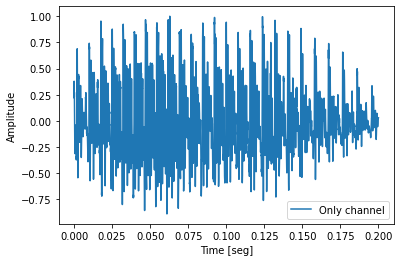

Duración:  0.20002083333333334 seg

A_068.wav


Duración:  0.20002083333333334 seg

A_010.wav


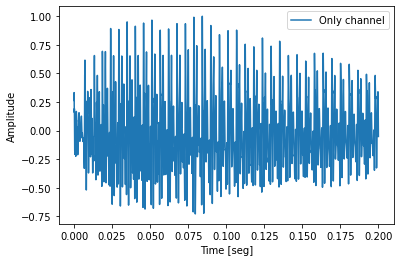

Duración:  0.20002083333333334 seg

A_048.wav


Duración:  0.20002083333333334 seg

A_087.wav


Duración:  0.20002083333333334 seg

A_97.wav


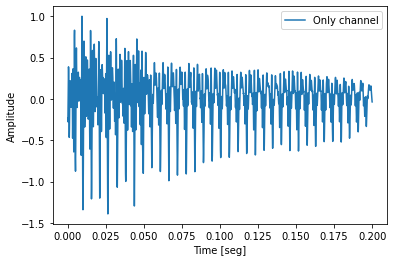

Duración:  0.20002083333333334 seg

A_91.wav


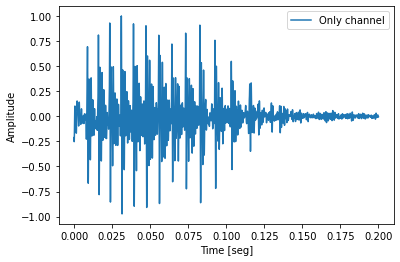

Duración:  0.20002083333333334 seg

A_076.wav


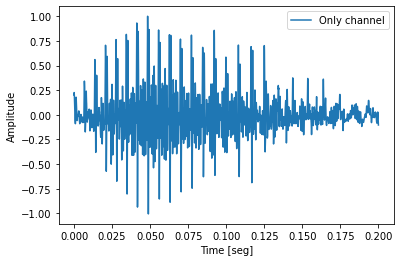

Duración:  0.20002083333333334 seg

A_036.wav


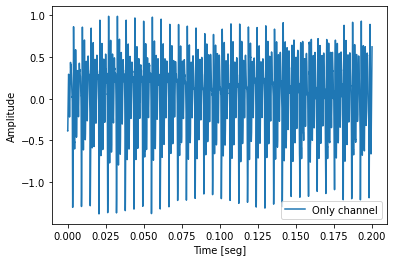

Duración:  0.20002083333333334 seg

A_069.wav


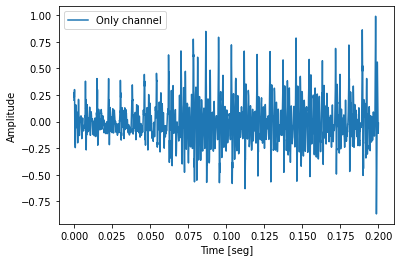

Duración:  0.20002083333333334 seg

A_021.wav


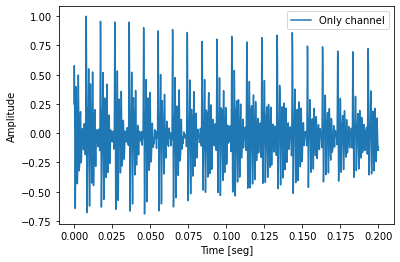

Duración:  0.20002083333333334 seg

A_039.wav


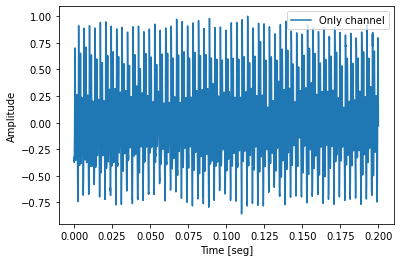

Duración:  0.20002083333333334 seg

A_023.wav


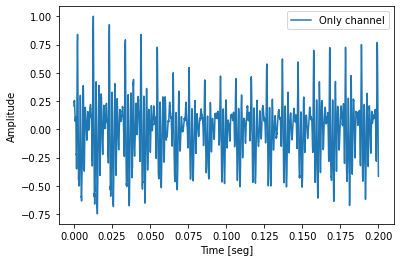

Duración:  0.20002083333333334 seg

A_073.wav


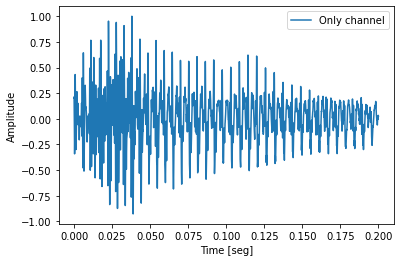

Duración:  0.20002083333333334 seg

A_004.wav


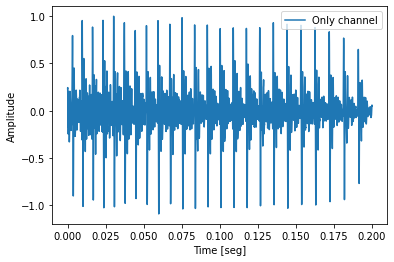

Duración:  0.20002083333333334 seg

A_012.wav


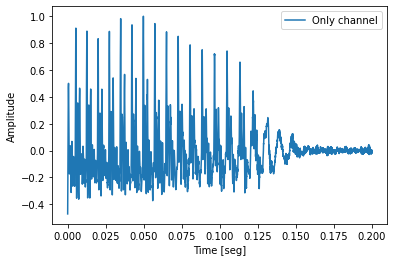

Duración:  0.20002083333333334 seg

A_086.wav


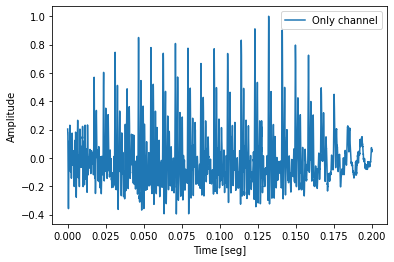

Duración:  0.20002083333333334 seg

A_056.wav


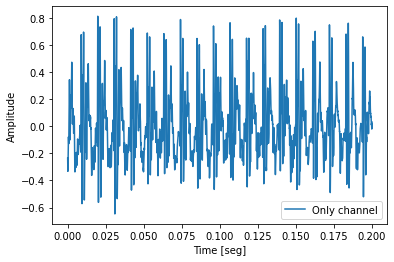

Duración:  0.20002083333333334 seg

A_051.wav


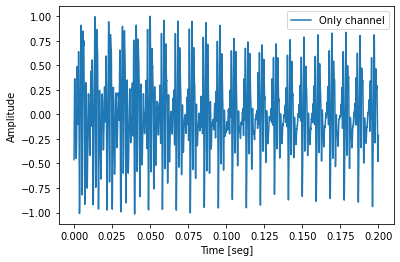

Duración:  0.20002083333333334 seg

A_015.wav


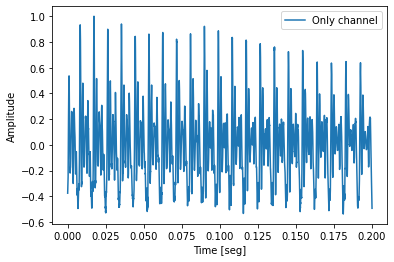

Duración:  0.20002083333333334 seg

A_014.wav


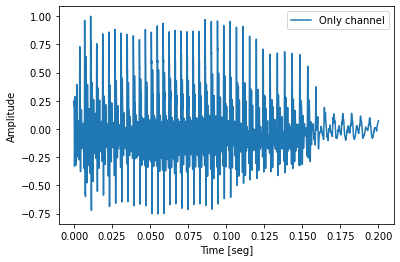

Duración:  0.20002083333333334 seg

A_038.wav


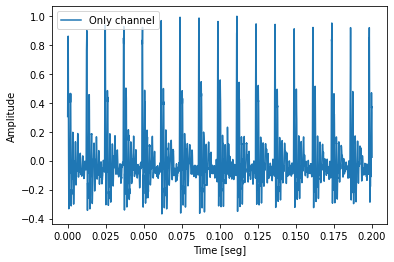

Duración:  0.20002083333333334 seg

A_040.wav


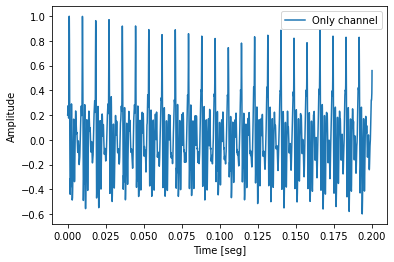

Duración:  0.20002083333333334 seg

A_041.wav


Duración:  0.20002083333333334 seg

A_016.wav


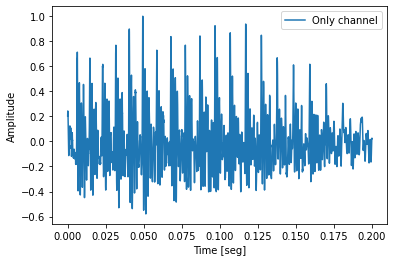

Duración:  0.20002083333333334 seg

A_055.wav


Duración:  0.20002083333333334 seg

A_081.wav


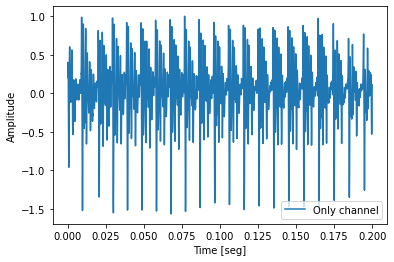

Duración:  0.20002083333333334 seg

A_007.wav


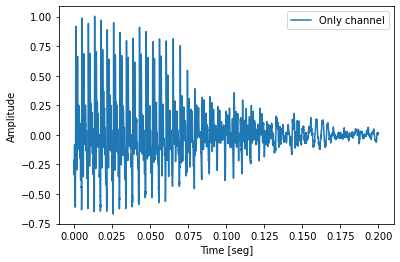

Duración:  0.20002083333333334 seg

A_035.wav


Duración:  0.20002083333333334 seg

A_005.wav


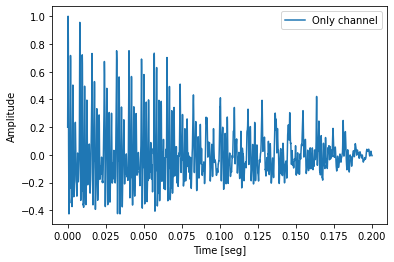

Duración:  0.20002083333333334 seg

A_089.wav


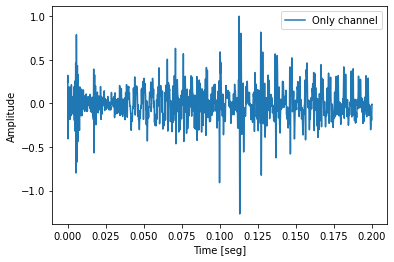

Duración:  0.20002083333333334 seg

A_024.wav


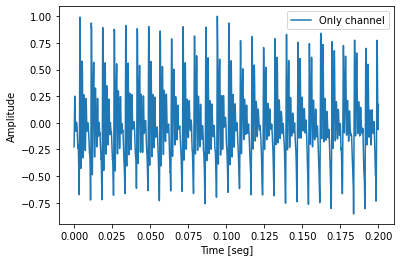

Duración:  0.20002083333333334 seg

A_050.wav


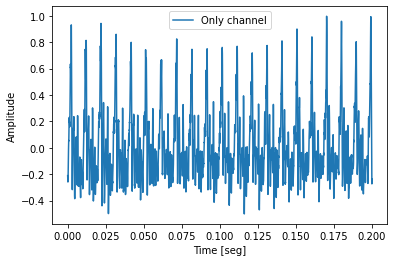

Duración:  0.20002083333333334 seg

A_071.wav


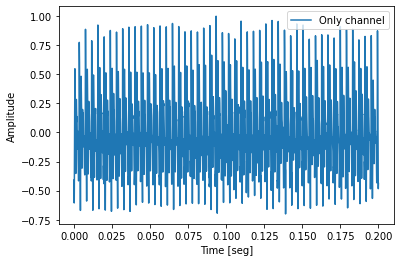

Duración:  0.20002083333333334 seg

A_044.wav


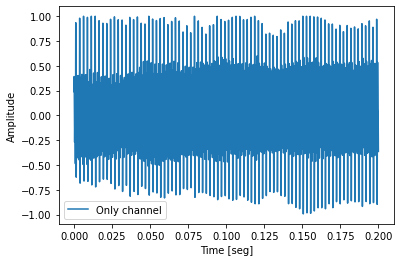

Duración:  0.20002083333333334 seg

A_037.wav


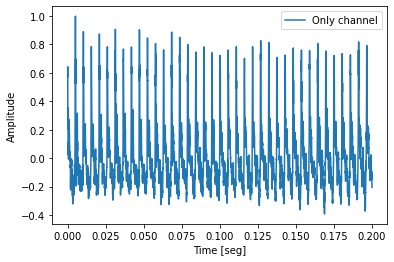

Duración:  0.20002083333333334 seg

A_070.wav


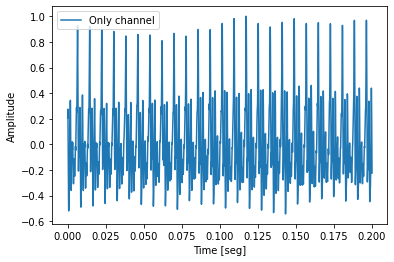

Duración:  0.20002083333333334 seg

A_074.wav


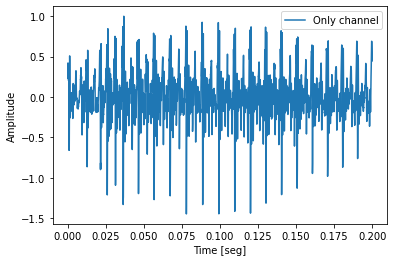

Duración:  0.20002083333333334 seg

A_072.wav


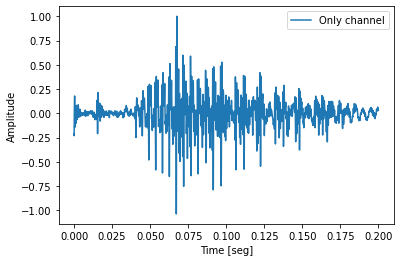

Duración:  0.20002083333333334 seg

A_080.wav


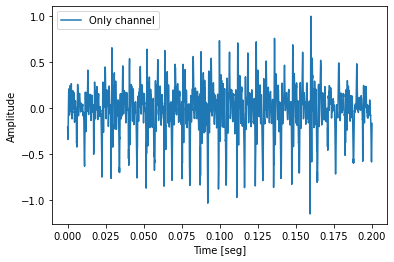

Duración:  0.20002083333333334 seg

A_025.wav


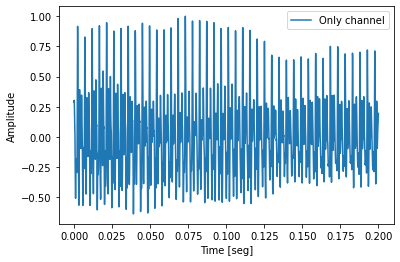

Duración:  0.20002083333333334 seg

A_98.wav
list index out of range

A_059.wav


Traceback (most recent call last):
  File "<ipython-input-66-4f22b07e974e>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


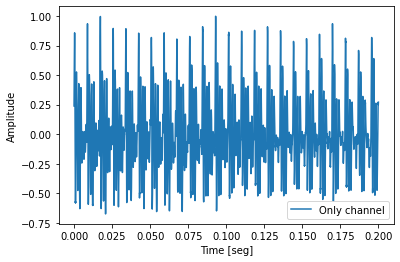

Duración:  0.20002083333333334 seg

A_008.wav


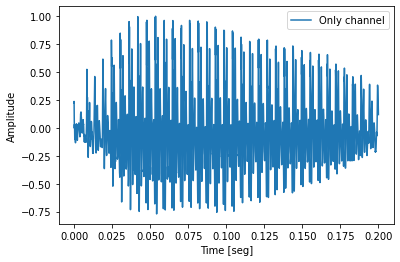

Duración:  0.20002083333333334 seg

A_067.wav


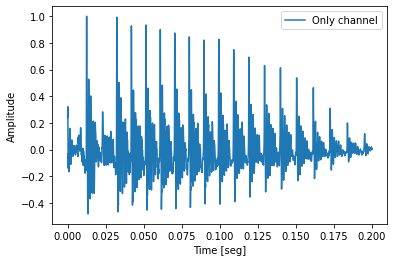

Duración:  0.20002083333333334 seg

A_018.wav


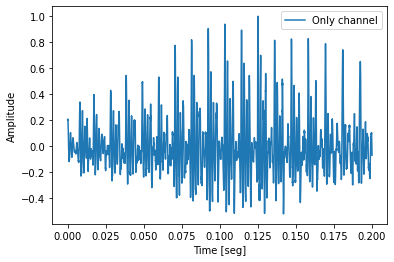

Duración:  0.20002083333333334 seg

A_064.wav


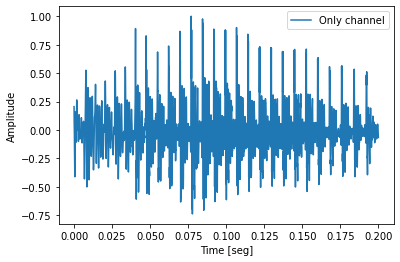

Duración:  0.20002083333333334 seg

A_088.wav


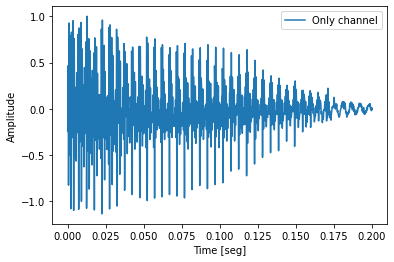

Duración:  0.20002083333333334 seg

A_034.wav


Duración:  0.20002083333333334 seg

A_066.wav


Duración:  0.20002083333333334 seg

A_049.wav


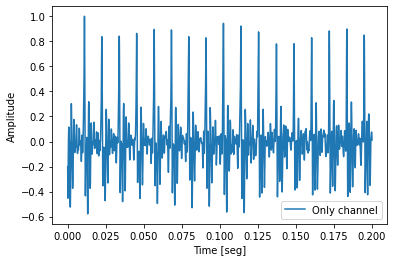

Duración:  0.20002083333333334 seg

A_078.wav


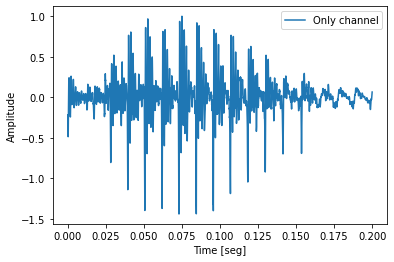

Duración:  0.20002083333333334 seg

A_083.wav


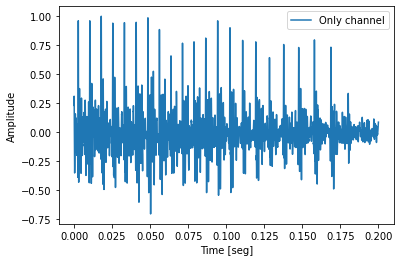

Duración:  0.20002083333333334 seg

A_075.wav


Duración:  0.20002083333333334 seg

A_95.wav


Duración:  0.20002083333333334 seg

A_013.wav


Duración:  0.20002083333333334 seg

A_001.wav


Duración:  0.20002083333333334 seg

A_020.wav


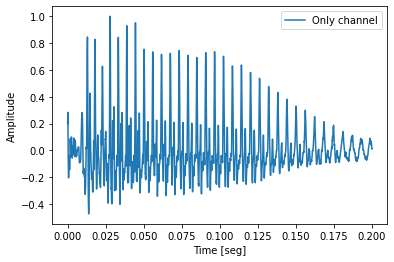

Duración:  0.20002083333333334 seg

A_090.wav


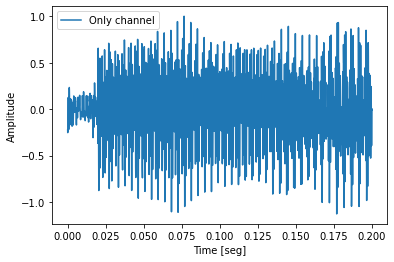

Duración:  0.20002083333333334 seg

A_029.wav


Duración:  0.20002083333333334 seg

A_047.wav


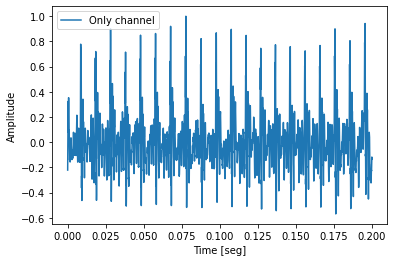

Duración:  0.20002083333333334 seg

A_058.wav


Duración:  0.20002083333333334 seg

A_085.wav


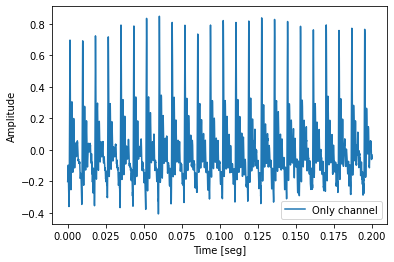

Duración:  0.20002083333333334 seg

A_084.wav


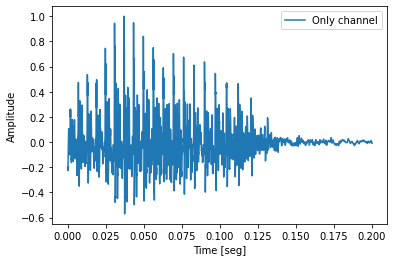

Duración:  0.20002083333333334 seg



In [ ]:
for a in A_records:
    try:
      print(a)
      samplerate, data = wavfile.read(path_A+'/'+a)
      filter_data = remove_silences_signal(samplerate, data)
      norm_data = normalize_signal(samplerate, filter_data)
      cut_data = cut_signal(samplerate, norm_data)
      visualize_wave(samplerate, cut_data)
    except Exception as exc:
        print(exc)
        traceback.print_exc()
    print()

Una vez tenemos la señal normalizada, lo que hacemos es obtener el **PSD** de la señal para un rango de frecuencias suficientemente grande (0, 5000) para distinguir cada una de las **vocales en sus respectivos rangos**.

In [ ]:
def get_psd(samplerate, rata):
    fs = samplerate
    f, Pxx_den = welch(rata, fs, nperseg=1024, scaling="spectrum")
    return (f, Pxx_den)

def visualize_psd(samplerate, data):
    fs = samplerate
    f, Pxx_den = welch(data, fs, nperseg=1024, scaling="spectrum")
    #print(f)
    #print(Pxx_den)
    plt.plot(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim([0, 5000])
    plt.show()

A continuación visualizamos cómo se ven los **PSD**s para todas los registros una vocal: **U**.

I_91.wav


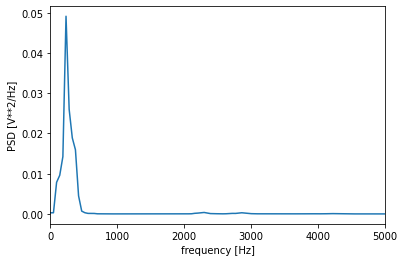


I_72.wav


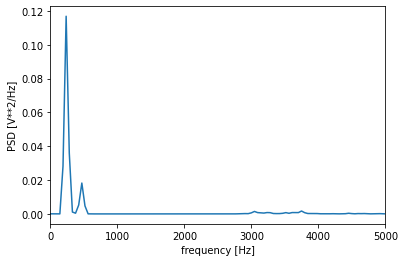


I_84.wav


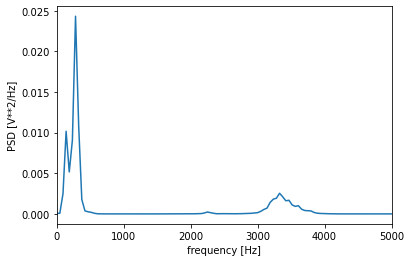


I_035.wav


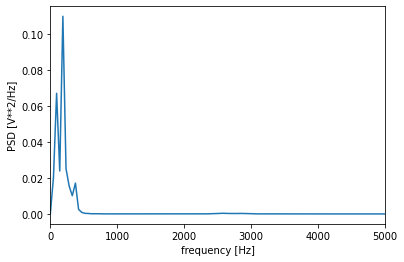


I_019.wav


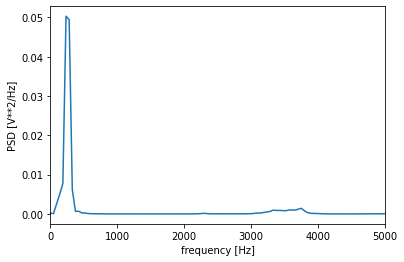


I_043.wav


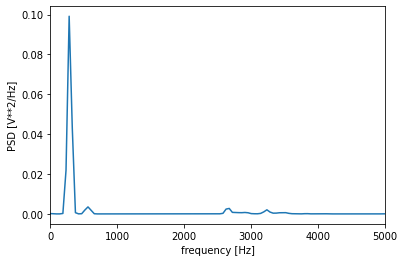


I_100.wav


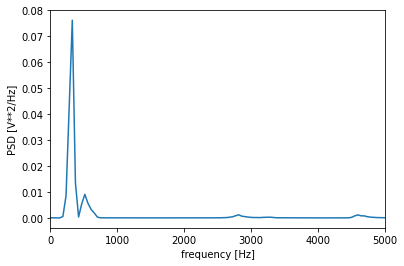


I_054.wav


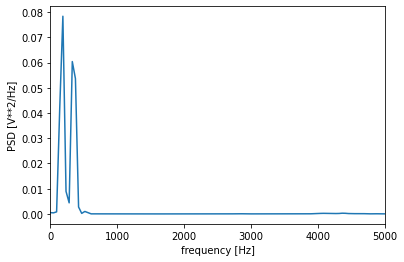


I_028.wav


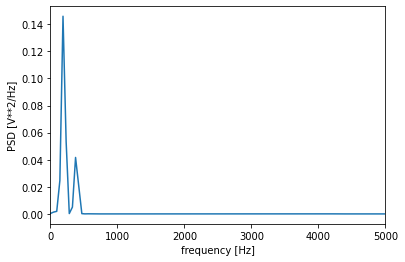


I_74.wav



I_83.wav



I_044.wav


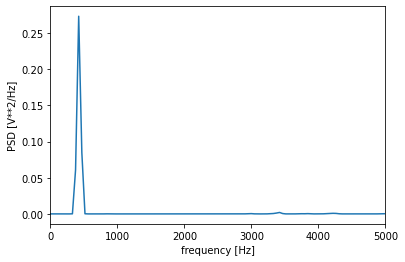


I_82.wav


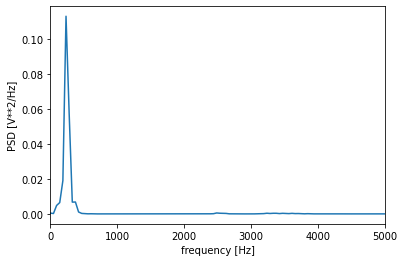


I_87.wav


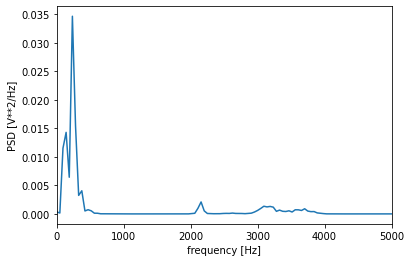


I_045.wav


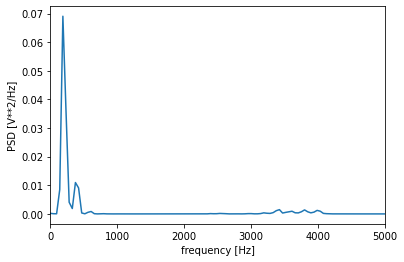


I_036.wav


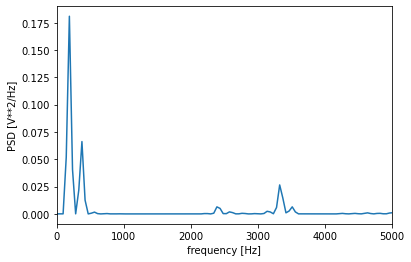


I_76.wav


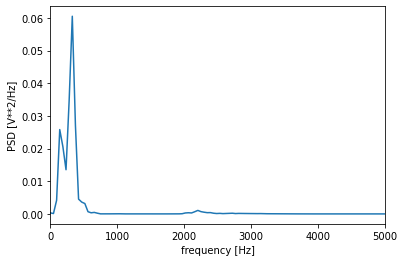


I_030.wav


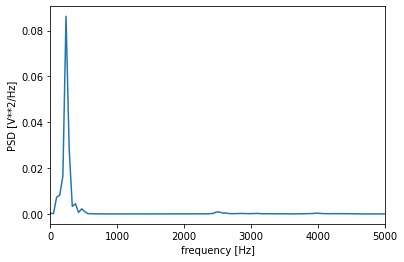


I_042.wav


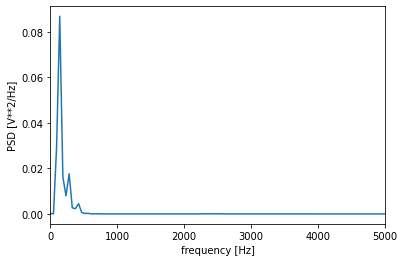


I_88.wav


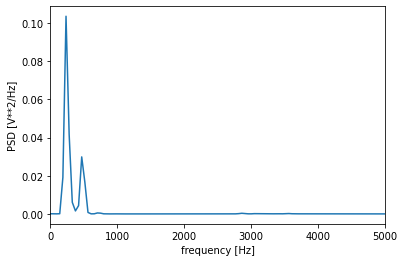


I_003.wav


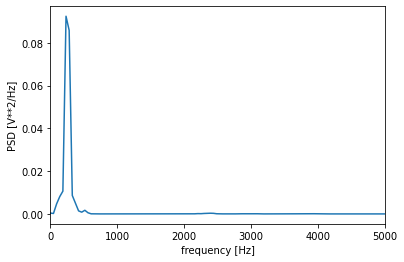


I_055.wav


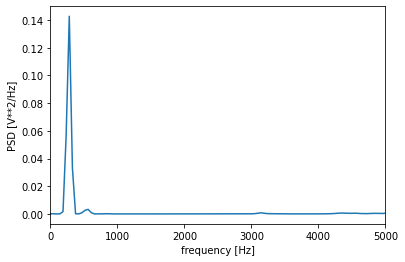


I_018.wav


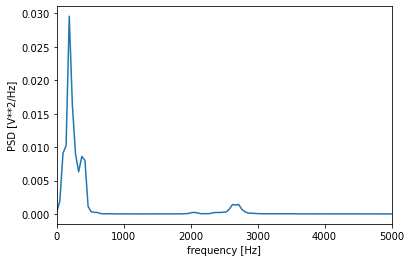


I_004.wav


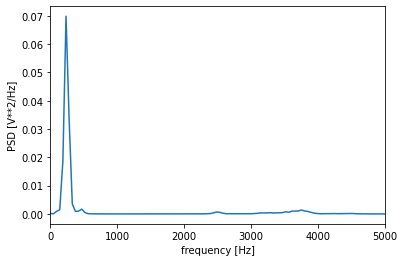


I_022.wav


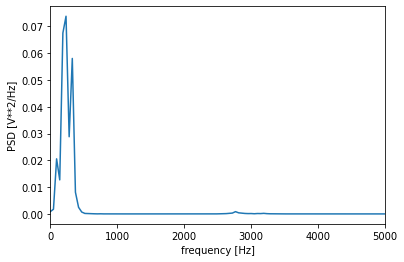


I_047.wav


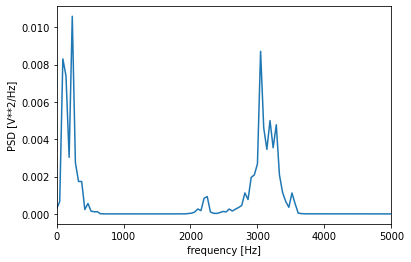


I_013.wav


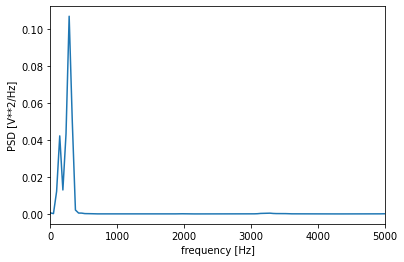


I_021.wav


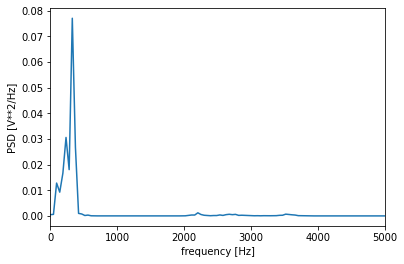


I_90.wav


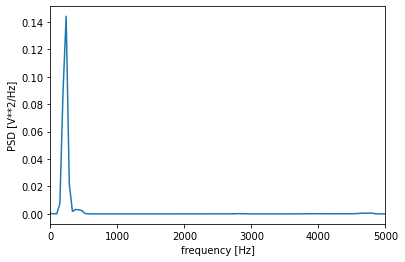


I_012.wav


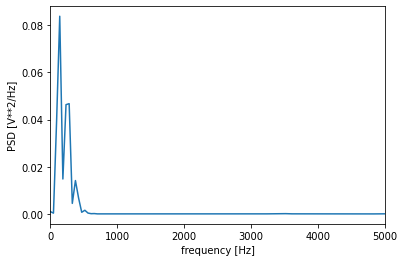


I_73.wav


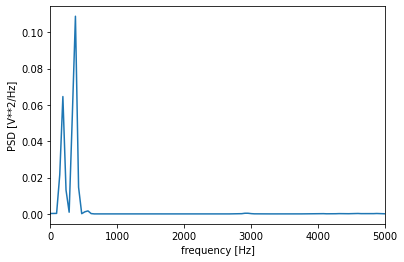


I_067.wav


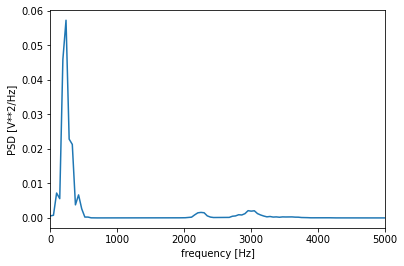


I_99.wav


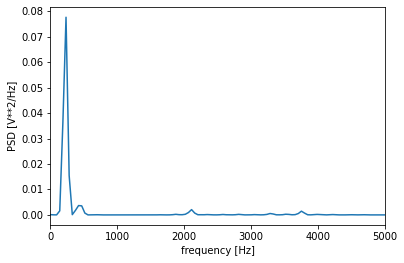


I_048.wav


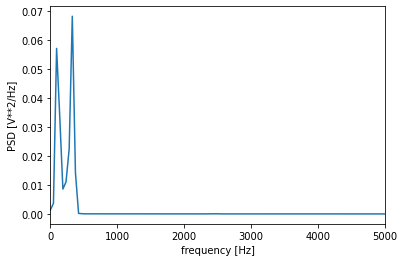


I_040.wav


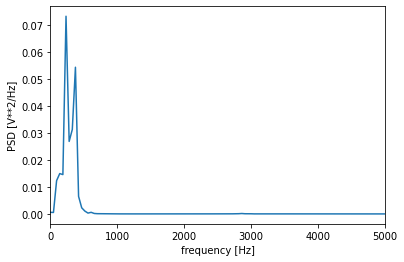


I_071.wav


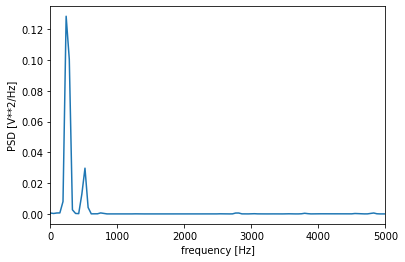


I_005.wav
list index out of range

I_027.wav


Traceback (most recent call last):
  File "<ipython-input-68-5fb916263773>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


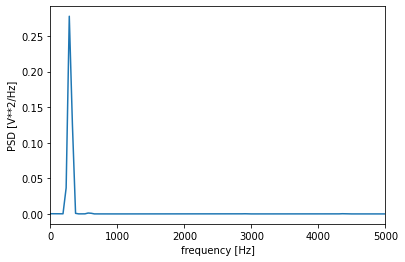


I_95.wav


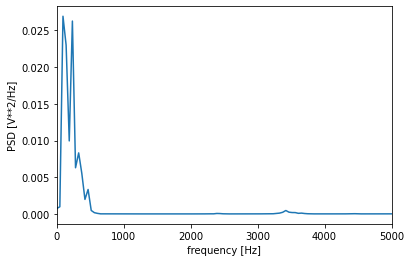


I_061.wav


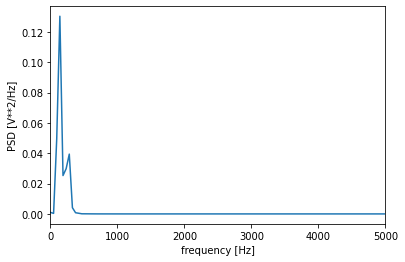


I_062.wav


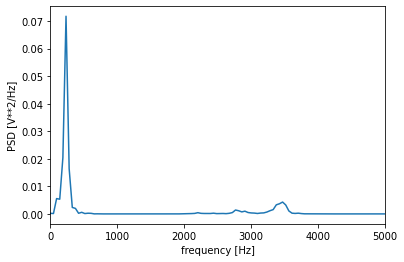


I_037.wav


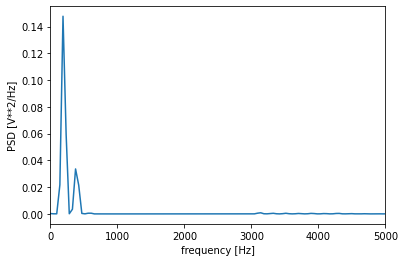


I_023.wav


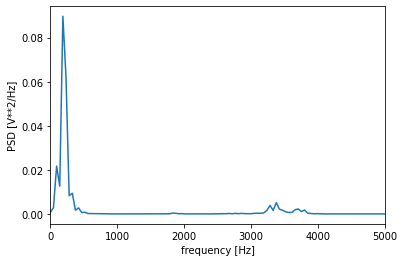


I_007.wav


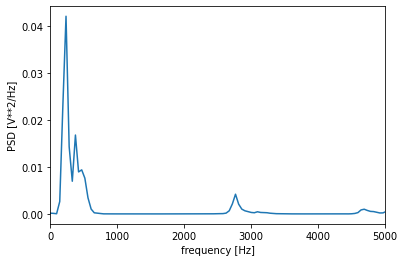


I_065.wav


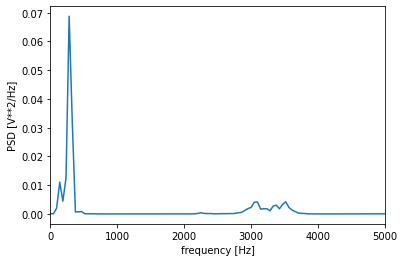


I_025.wav


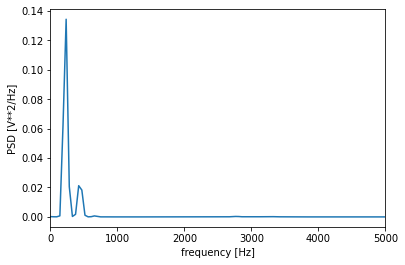


I_068.wav


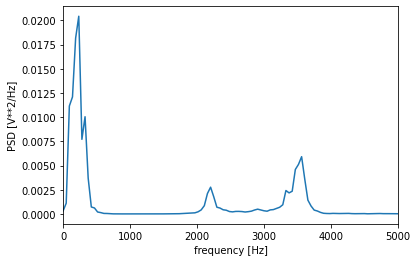


I_010.wav


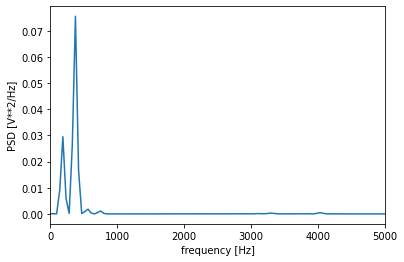


I_016.wav


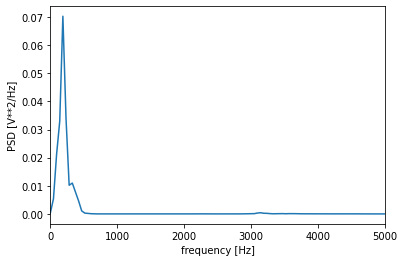


I_79.wav


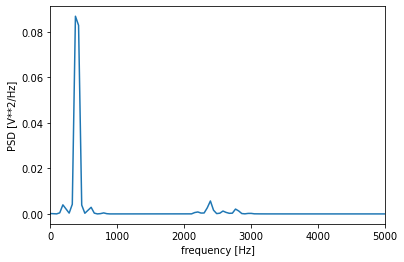


I_75.wav


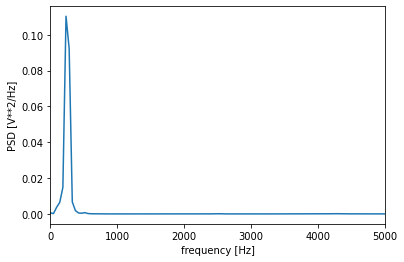


I_008.wav


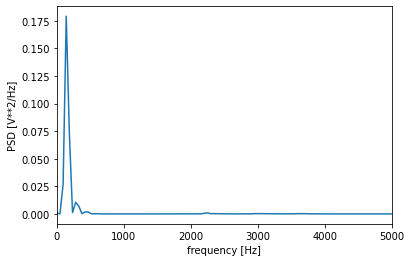


I_053.wav


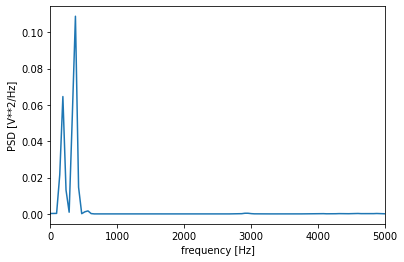


I_058.wav


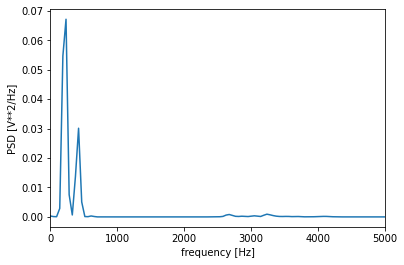


I_96.wav



I_001.wav


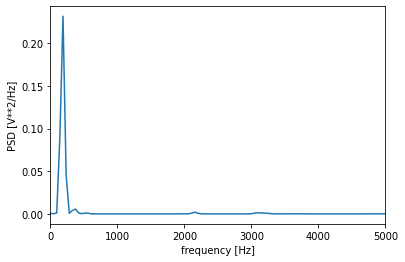


I_064.wav



I_050.wav


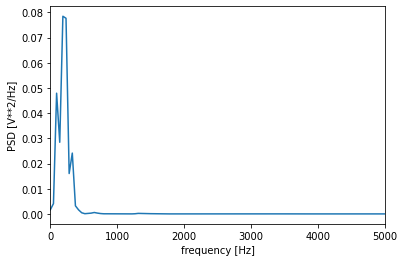


I_002.wav
list index out of range

I_052.wav


Traceback (most recent call last):
  File "<ipython-input-68-5fb916263773>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range



I_063.wav


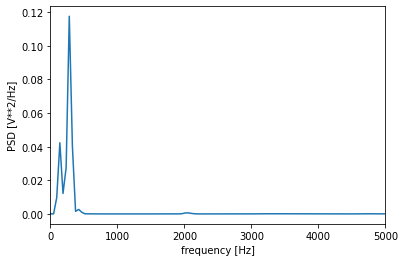


I_031.wav



I_057.wav


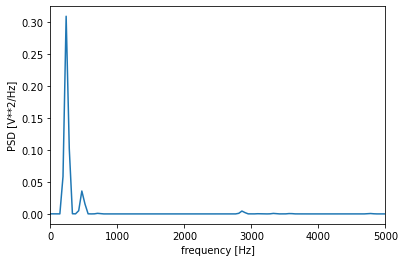


I_89.wav


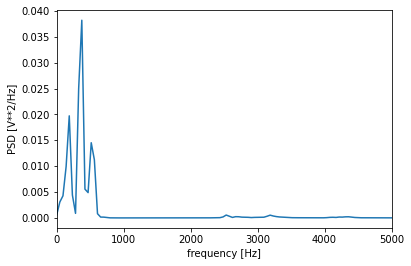


I_94.wav



I_020.wav


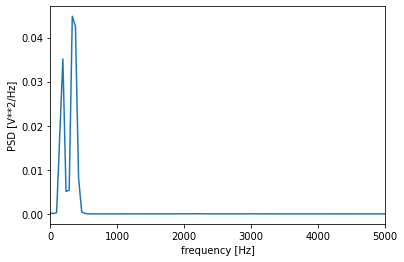


I_069.wav


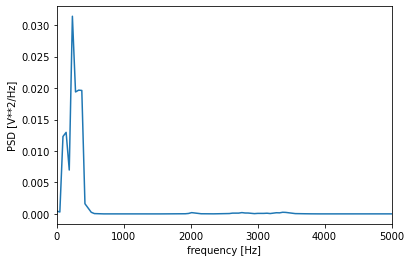


I_059.wav



I_041.wav


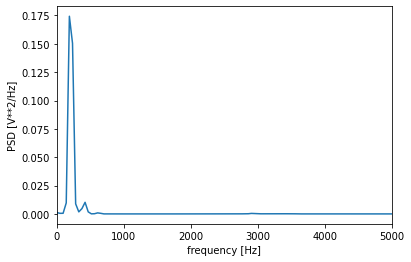


I_015.wav



I_051.wav


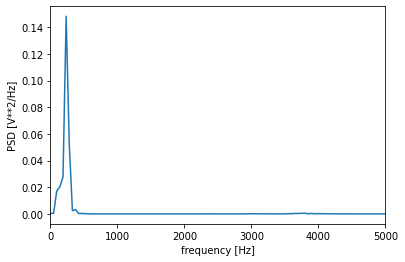


I_80.wav


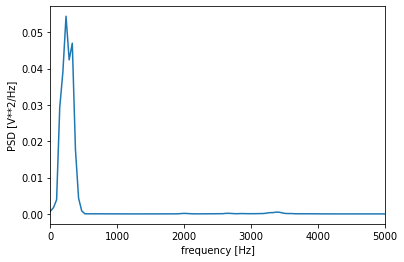


I_77.wav


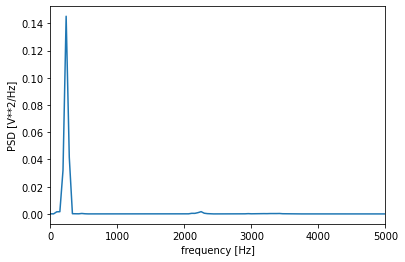


I_011.wav


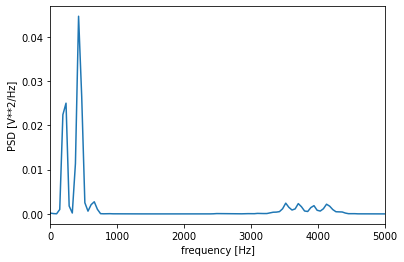


I_81.wav


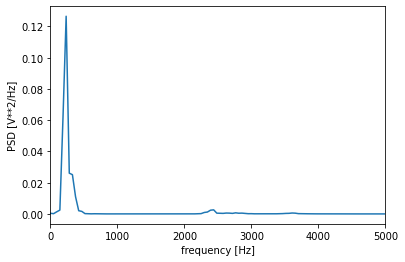


I_033.wav


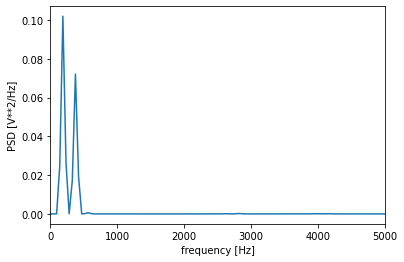


I_060.wav


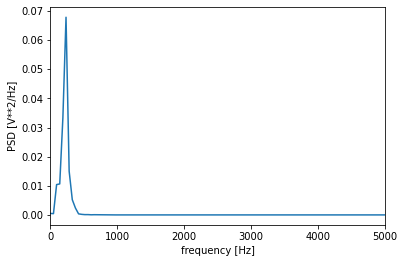


I_032.wav


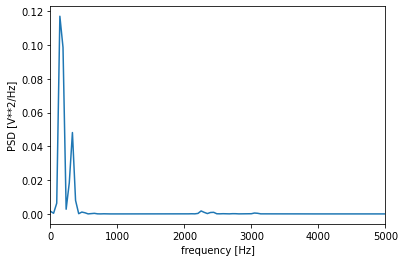


I_006.wav


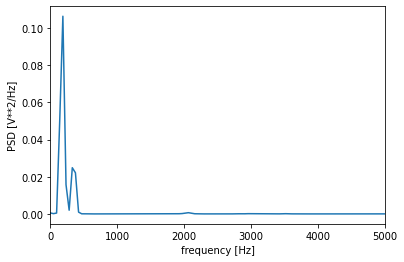


I_066.wav


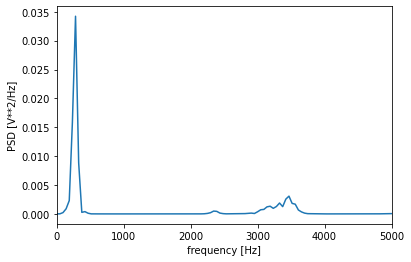


I_017.wav


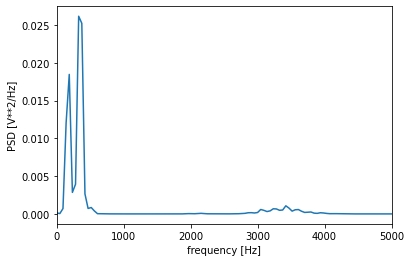


I_98.wav


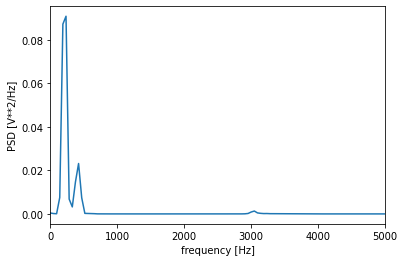


I_024.wav


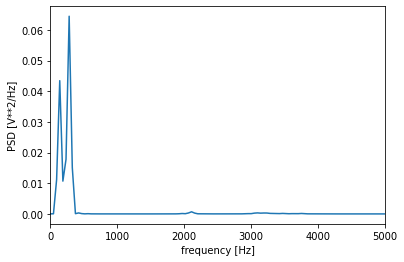


I_070.wav


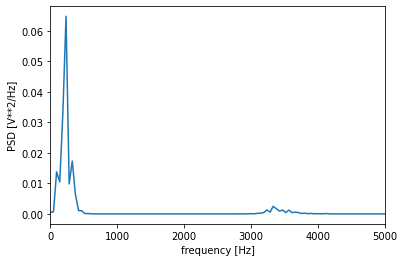


I_034.wav


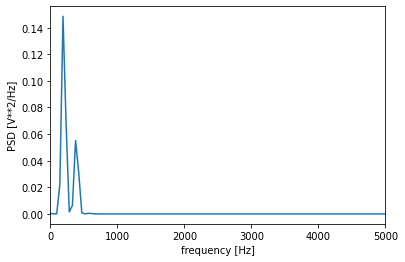


I_056.wav


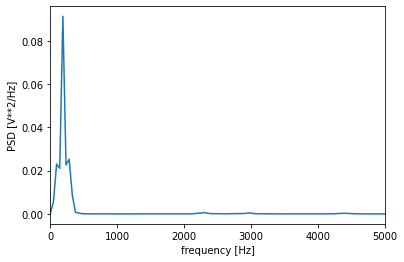


I_038.wav


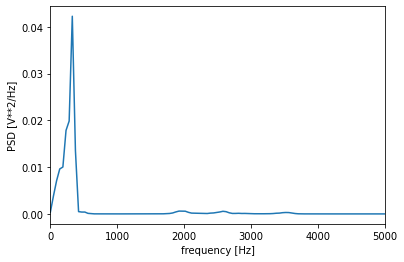


I_85.wav


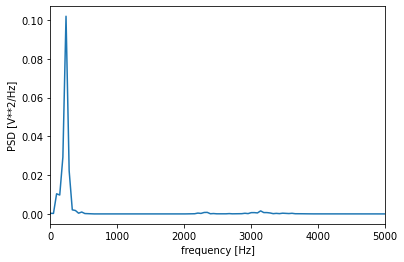


I_026.wav


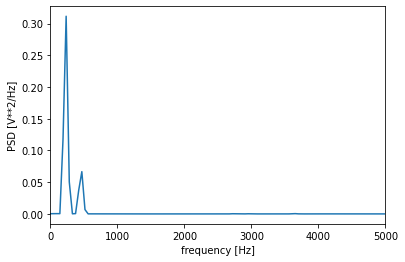


I_046.wav


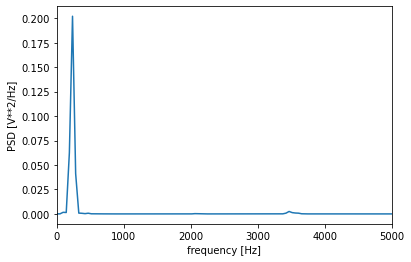


I_78.wav


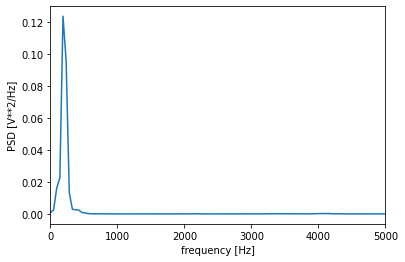


I_93.wav



I_039.wav



I_014.wav


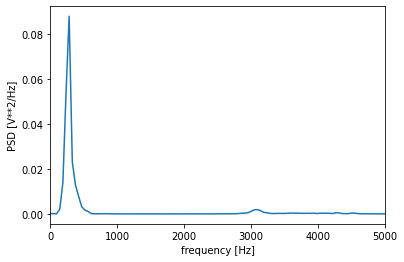


I_97.wav



I_009.wav


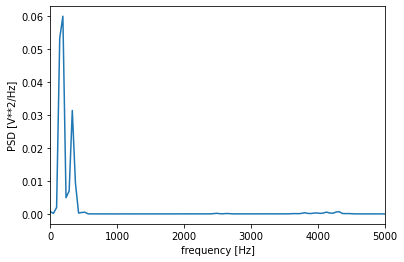


I_86.wav


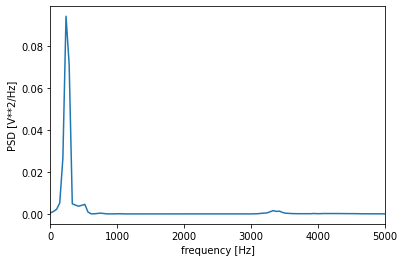


I_029.wav


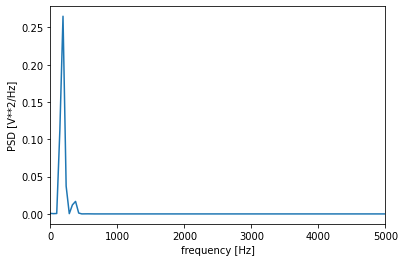


I_92.wav


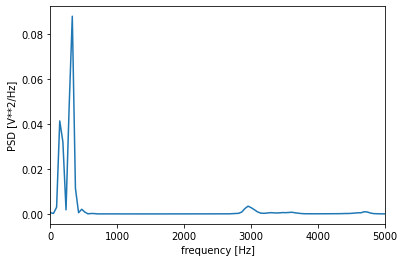

In [ ]:
for i in I_records:
    try:
      print(i)
      samplerate, data = wavfile.read(path_I+'/'+i)
      filter_data = remove_silences_signal(samplerate, data)
      norm_data = normalize_signal(samplerate, filter_data)
      cut_data = cut_signal(samplerate, norm_data)
      visualize_psd(samplerate, cut_data)
      #print(get_psd(samplerate, norm_data)[0].shape)
    except Exception as exc:
        print(exc)
        traceback.print_exc()
    print()

**Integral bajo la curva de densidad**: la idea es utilizar el area bajo la curva de la densidad para caracterizar cada vocal. Vimos que algunas vocales concentran una mayor densidad en rangos de frecuencia muy especificos, que varían de una a otra. Esto hace que un vector de **integrales definidas** entre dos frecuencias, que especifican un rango de frecuencia, sean una variable predictora significativa. De hecho, en la siguientes sección verificamos que nuestra intuición sea correcta, implementando una red neural con el **vector de integrales** como entrada.

Para eso, lo primero que hacemos es definir los límites de integración, es decir, los rangos de frecuencias para los cuales calcularemos el area bajo la curva de su densidad. Para esto, la entrada son las frecuencias límites de los rangos, y se divide el intervalo de frecuencia en los **subintervalos** definidos por los límites. Luego utilizaremos estos **subintervalos** para calcular las integrales definidas.

In [ ]:
def divide_subintervals(density_vec, frecuency_vec, frecuencies):
    sub_intervals = []
    for i in range(len(frecuencies)-1):
        frec_inf = frecuencies[i]
        frec_sup = frecuencies[i+1]
        sub_int = []
        for j in range(len(frecuency_vec)):
            if frec_inf <= frecuency_vec[j] and frecuency_vec[j] <= frec_sup:
                sub_int.append(density_vec[j])
        sub_intervals.append(sub_int)
    #print(sub_intervals)
    return sub_intervals

En el siguiente cuadro de código definimos los límites de integración: los límites en los que se divide el dominio de frecuencia.

In [ ]:
frec_limits = []
intervals = 100
for i in range(intervals):
    frec_limits.append(i * (5000/intervals))
#frec_limits = [0, 1000, 5000]

Realizamos una **prueba unitaria** para verificar que la función *divide_subintervals* funciona apropiadamente: vemos que si.

In [ ]:
samplerate, data = wavfile.read(path_U+'/'+U_records[1])
filter_data = remove_silences_signal(samplerate, data)
norm_data = normalize_signal(samplerate, filter_data)
cut_data = cut_signal(samplerate, norm_data)
frecs, dens = get_psd(samplerate, norm_data)
sub_intervals = divide_subintervals(dens, frecs, frec_limits)
#print(dens)
for sub_int in sub_intervals:
    print(len(sub_int))
print(sub_intervals)

2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
[[9.234825996540553e-05, 4.291083855033628e-05], [0.0013865974030613075], [0.002942018888881956], [0.001581822510685627], [0.014433816560481953], [0.02019987204352456], [0.005081685813132723], [0.00334852890232587], [0.0020074897579826913], [0.0008745482473795072], [0.00137362891620964], [0.0023399050566411173], [0.005709180533545961], [0.0043034078079164165], [0.0009050061990481508, 0.00023707328453519952], [0.00023707328453519952, 3.901881454185774e-05], [1.590979658085416e-05], [7.831694560948833e-06], [4.149952519899144e-06], [2.969022572408948e-06], [1.2209467126743255e-06], [3.3157854249187845e-07], [4.766202596464602e-07], [5.248015210489695e-07], [4.3084697316838915e-07], [4.198884584876765e-07], [2.9318369025706865e-07], [1.9693887479079605e-07], [9.255044158006349e-08], [9.57587425

Ya dividimos el dominio de frecuencias en subintervalos sobre los cuales realizar las **integrales definidas**. A continuación, calculamos las integrales definidas para cada uno de esos subintervalos: **sumamos los elementos de densidad que a los cuales corresponde las frecuencias de cada subintervalo**.

In [ ]:
integrales_definidas_U = []
for u in U_records:
    try:
      samplerate, data = wavfile.read(path_U+'/'+u)
      filter_data = remove_silences_signal(samplerate, data)
      norm_data = normalize_signal(samplerate, filter_data)
      cut_data = cut_signal(samplerate, norm_data)
      frecs, dens = get_psd(samplerate, norm_data)
      sub_intervals = divide_subintervals(dens, frecs, frec_limits)

      integrales_definidas = []
      inter = []
      for sub_int in sub_intervals:
          integrales_definidas.append(sum(sub_int))
      integrales_definidas_U.append(integrales_definidas)
    except Exception as exc:
        print(exc)
        traceback.print_exc()

list index out of range


Traceback (most recent call last):
  File "<ipython-input-72-2938ce55b41d>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


list index out of range


Traceback (most recent call last):
  File "<ipython-input-72-2938ce55b41d>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


list index out of range


Traceback (most recent call last):
  File "<ipython-input-72-2938ce55b41d>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


list index out of range


Traceback (most recent call last):
  File "<ipython-input-72-2938ce55b41d>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


In [ ]:
integrales_definidas_O = []
for o in O_records:
    try:
      samplerate, data = wavfile.read(path_O+'/'+o)
      filter_data = remove_silences_signal(samplerate, data)
      norm_data = normalize_signal(samplerate, filter_data)
      cut_data = cut_signal(samplerate, norm_data)
      frecs, dens = get_psd(samplerate, norm_data)
      sub_intervals = divide_subintervals(dens, frecs, frec_limits)

      integrales_definidas = []
      inter = []
      for sub_int in sub_intervals:
          integrales_definidas.append(sum(sub_int))
      integrales_definidas_O.append(integrales_definidas)
    except Exception as exc:
        print(exc)
        traceback.print_exc()

list index out of range


Traceback (most recent call last):
  File "<ipython-input-73-28b6875e79e6>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


list index out of range


Traceback (most recent call last):
  File "<ipython-input-73-28b6875e79e6>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


In [ ]:
integrales_definidas_I = []
for i in I_records:
    try:
      samplerate, data = wavfile.read(path_I+'/'+i)
      filter_data = remove_silences_signal(samplerate, data)
      norm_data = normalize_signal(samplerate, filter_data)
      cut_data = cut_signal(samplerate, norm_data)
      frecs, dens = get_psd(samplerate, norm_data)
      sub_intervals = divide_subintervals(dens, frecs, frec_limits)

      integrales_definidas = []
      inter = []
      for sub_int in sub_intervals:
          integrales_definidas.append(sum(sub_int))
      integrales_definidas_I.append(integrales_definidas)
    except Exception as exc:
        print(exc)
        traceback.print_exc()

list index out of range


Traceback (most recent call last):
  File "<ipython-input-74-4550acfc1c6e>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


list index out of range


Traceback (most recent call last):
  File "<ipython-input-74-4550acfc1c6e>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


In [ ]:
integrales_definidas_E = []
for e in E_records:
    try:
      samplerate, data = wavfile.read(path_E+'/'+e)
      filter_data = remove_silences_signal(samplerate, data)
      norm_data = normalize_signal(samplerate, filter_data)
      cut_data = cut_signal(samplerate, norm_data)
      frecs, dens = get_psd(samplerate, norm_data)
      sub_intervals = divide_subintervals(dens, frecs, frec_limits)

      integrales_definidas = []
      inter = []
      for sub_int in sub_intervals:
          integrales_definidas.append(sum(sub_int))
      integrales_definidas_E.append(integrales_definidas)
    except Exception as exc:
        print(exc)
        traceback.print_exc()

list index out of range


Traceback (most recent call last):
  File "<ipython-input-75-9a35e2c73e38>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


In [ ]:
integrales_definidas_A = []
for a in A_records:
    try:
      samplerate, data = wavfile.read(path_A+'/'+a)
      filter_data = remove_silences_signal(samplerate, data)
      norm_data = normalize_signal(samplerate, filter_data)
      cut_data = cut_signal(samplerate, norm_data)
      frecs, dens = get_psd(samplerate, norm_data)
      sub_intervals = divide_subintervals(dens, frecs, frec_limits)

      integrales_definidas = []
      inter = []
      for sub_int in sub_intervals:
          integrales_definidas.append(sum(sub_int))
      integrales_definidas_A.append(integrales_definidas)
    except Exception as exc:
        print(exc)
        traceback.print_exc()

list index out of range


Traceback (most recent call last):
  File "<ipython-input-76-f1a937140f86>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


list index out of range


Traceback (most recent call last):
  File "<ipython-input-76-f1a937140f86>", line 7, in <module>
    cut_data = cut_signal(samplerate, norm_data)
  File "<ipython-input-65-d61a5ed33d61>", line 18, in cut_signal
    cut_data.append(data[i])
IndexError: list index out of range


#**Red neuronal**

Ya tenemos las integrales definidas para cada uno de los subintervalos del dominio de frecuencias. Podemos graficar en el eje **intervalo de frecuencia VS integral definida sobre ese intervalo** cómo cambia la integral de un intervalo a otro: de acuerdo a las gráficas de los **PSD** esperaríamos que conforme aumenta el intervalo la integral disminuya, ya que las mayorías de vocales concentran una mayor densidad en el primer **formante** (**es decir, en frecuencias menores que 2000 Hz**).

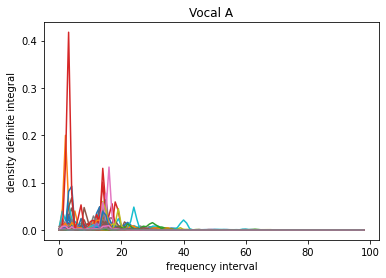

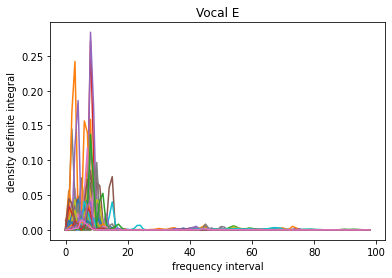

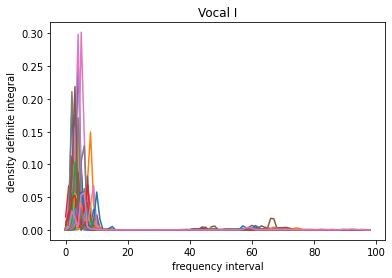

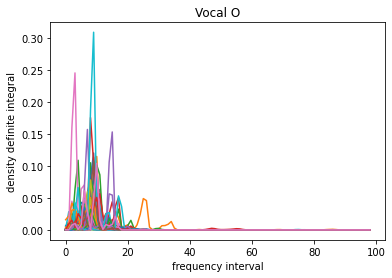

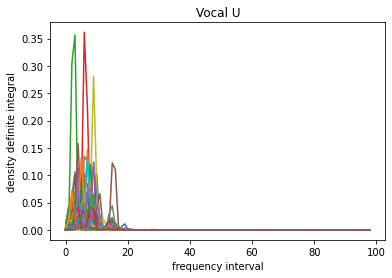

In [ ]:
U_data = pd.DataFrame(integrales_definidas_U)
U_data

plt.title('Vocal A')
plt.xlabel('frequency interval')
plt.ylabel('density definite integral')
for int_a in integrales_definidas_A:
    plt.plot(int_a)
plt.show()
plt.title('Vocal E')
plt.xlabel('frequency interval')
plt.ylabel('density definite integral')
for int_e in integrales_definidas_E:
    plt.plot(int_e)
plt.show()
plt.title('Vocal I')
plt.xlabel('frequency interval')
plt.ylabel('density definite integral')
for int_i in integrales_definidas_I:
    plt.plot(int_i)
plt.show()
plt.title('Vocal O')
plt.xlabel('frequency interval')
plt.ylabel('density definite integral')
for int_o in integrales_definidas_O:
    plt.plot(int_o)
plt.show()
plt.title('Vocal U')
plt.xlabel('frequency interval')
plt.ylabel('density definite integral')
for int_u in integrales_definidas_U:
    plt.plot(int_u)
plt.show()

En efecto, podemos ver que las **integrales definidas** que definimos anteriormente parecen ser un predictor significativo, ya que permite distinguir diferencias de una vocal a la otra: cada vocal concentra una mayor densidad en intervalos muy especificos llamados **formantes**. Teóricamente son los **formates** los que permiten al oido humano diferenciar la pronunciación de las vocales.

Con base en esta información, a continuación, construimos el **dataset** para el entrenamiento de la **red neural**: etiquetaremos cada **vector de integrales definidas** con la vocal de la cual se obtuvo. Vemos que entre observaciones de la misma vocal los **vectores de integrales definidas** presentan una similitud conveniente. Aprovechamos este último hecho para la clasificación: esperamos que la máquina sea capaz de aprender los **formates** y caracterizar cada vocal de acuerdo a estos.

En el siguiente **dataset** los identificadores de las **columnas** corresponden a cada **subintervalo** sobre el cual se realizó la **integral definida**, mientras que los identificadores de las **filas** corresponden a la observación de la vocal (**nota de voz**), y cada entrada corresponde a la **integral definida** para la i-ésima nota de voz en j-ésimo subintervalo.

In [ ]:
dataset_A = pd.DataFrame(integrales_definidas_A)
dataset_A['vocal'] = dataset_A[0].apply(lambda x: 0 if True else 0)
dataset_E = pd.DataFrame(integrales_definidas_E)
dataset_E['vocal'] = dataset_E[0].apply(lambda x: 1 if True else 1)
dataset_I = pd.DataFrame(integrales_definidas_I)
dataset_I['vocal'] = dataset_I[0].apply(lambda x: 2 if True else 2)
dataset_O = pd.DataFrame(integrales_definidas_O)
dataset_O['vocal'] = dataset_O[0].apply(lambda x: 3 if True else 3)
dataset_U = pd.DataFrame(integrales_definidas_U)
dataset_U['vocal'] = dataset_U[0].apply(lambda x: 4 if True else 4)

In [ ]:
dataset_O

0             1             2             3             4  \
0   0.000148  7.291913e-04  2.565650e-03  1.964335e-03  7.373877e-04   
1   0.000033  1.134394e-07  1.704221e-07  1.348303e-07  2.425535e-07   
2   0.000020  8.135753e-06  3.272273e-04  1.707349e-03  1.496430e-03   
3   0.000050  5.303544e-05  8.067768e-04  1.383700e-03  1.487404e-03   
4   0.001147  1.197474e-02  8.210953e-03  7.684352e-03  1.387556e-02   
..       ...           ...           ...           ...           ...   
92  0.000049  4.710881e-04  1.748488e-03  5.322414e-04  2.978424e-03   
93  0.000491  9.362527e-03  1.515037e-02  3.636360e-03  2.540292e-02   
94  0.000041  8.203325e-06  2.061947e-03  1.002111e-02  4.695888e-03   
95  0.000237  4.378378e-04  9.109641e-03  8.559871e-03  3.628095e-04   
96  0.000253  2.172309e-04  7.710623e-03  1.000793e-02  6.749351e-04   

               5         6         7         8         9  ...            90  \
0   1.079249e-03  0.001456  0.001334  0.003877  0.019257  ...  1.245879e-08   
1   8.280436e-07  0.000027  0.001427  0.005088  0.001766  ...  3.883469e-05   
2   1.749787e-04  0.000885  0.001561  0.000438  0.000070  ...  1.052821e-06   
3   2.154701e-03  0.002117  0.001173  0.001648  0.005011  ...  6.096420e-06   
4   5.656001e-03  0.020480  0.010142  0.052081  0.044331  ...  7.482012e-08   
..           ...       ...       ...       ...       ...  ...           ...   
92  9.364863e-03  0.003154  0.007101  0.032092  0.018798  ...  5.148366e-07   
93  1.813313e-02  0.005103  0.020780  0.010788  0.035736  ...  1.250937e-08   
94  9.719429e-04  0.005599  0.026967  0.015094  0.004313  ...  3.244859e-07   
95  8.819608e-03  0.029432  0.007232  0.004648  0.050418  ...  1.428151e-06   
96  8.334467e-03  0.061181  0.028115  0.000747  0.048137  ...  5.722705e-08   

              91            92            93            94            95  \
0   5.165491e-09  4.426569e-09  4.390553e-09  5.268096e-09  6.240704e-09   
1   1.397565e-05  3.246894e-05  4.879480e-05  6.009620e-05  5.802496e-05   
2   2.429486e-07  1.373634e-07  1.240441e-07  1.290439e-07  1.181377e-07   
3   4.430294e-07  2.037292e-07  1.279500e-07  1.003725e-07  9.687888e-08   
4   3.500897e-08  4.107125e-08  3.618794e-08  2.460022e-08  2.119218e-08   
..           ...           ...           ...           ...           ...   
92  6.589078e-07  2.683530e-07  2.692291e-07  2.191730e-07  2.681183e-07   
93  6.809483e-09  6.172656e-09  5.928792e-09  4.750362e-09  6.093555e-09   
94  1.608769e-07  1.591053e-07  2.331496e-07  2.678430e-07  2.704642e-07   
95  1.508213e-07  3.184963e-07  4.219061e-07  2.983102e-07  1.873619e-07   
96  5.234279e-08  6.876281e-08  6.286240e-08  7.791830e-08  1.168317e-07   

              96            97            98  vocal  
0   5.727993e-09  5.878382e-09  5.249441e-09      3  
1   1.302380e-05  5.112598e-06  3.511095e-06      3  
2   1.335155e-07  1.696092e-07  1.675535e-07      3  
3   4.664367e-08  4.462338e-08  4.612554e-08      3  
4   2.305852e-08  1.842026e-08  1.891170e-08      3  
..           ...           ...           ...    ...  
92  2.681650e-07  3.851504e-07  5.951791e-07      3  
93  4.333889e-09  4.302143e-09  5.293830e-09      3  
94  1.648738e-07  1.124623e-07  6.291185e-08      3  
95  2.356696e-07  1.387490e-07  7.573495e-08      3  
96  1.704471e-07  1.327561e-07  1.968337e-07      3  

[97 rows x 100 columns]

In [ ]:
frames = [dataset_A, dataset_E, dataset_I, dataset_O, dataset_U]
dataset = pd.concat(frames)
dataset

0         1         2         3         4         5         6  \
0   0.000082  0.000048  0.004860  0.015324  0.003858  0.000158  0.002616   
1   0.000152  0.044891  0.199901  0.056277  0.008720  0.039942  0.011967   
2   0.000054  0.000422  0.000473  0.000730  0.002345  0.000758  0.000248   
3   0.000182  0.000183  0.002146  0.004030  0.000738  0.000393  0.003011   
4   0.000905  0.012631  0.010204  0.001223  0.001562  0.000655  0.001192   
..       ...       ...       ...       ...       ...       ...       ...   
91  0.000339  0.017734  0.071497  0.019768  0.032974  0.131708  0.046212   
92  0.002401  0.001365  0.002604  0.047992  0.059833  0.004673  0.000226   
93  0.000325  0.000096  0.000618  0.020618  0.042574  0.007636  0.001383   
94  0.000288  0.000292  0.000148  0.011938  0.070188  0.025747  0.000100   
95  0.000250  0.000457  0.001822  0.001409  0.003473  0.027591  0.034506   

           7         8         9  ...            90            91  \
0   0.005268  0.001175  0.000412  ...  1.902637e-06  3.702324e-07   
1   0.000721  0.002375  0.000601  ...  9.715876e-07  3.802974e-07   
2   0.000203  0.000135  0.000347  ...  4.031849e-08  3.894923e-08   
3   0.003119  0.000387  0.000408  ...  7.108262e-07  3.350288e-07   
4   0.000699  0.000559  0.000444  ...  1.969626e-05  9.670687e-06   
..       ...       ...       ...  ...           ...           ...   
91  0.001313  0.001398  0.000379  ...  1.718623e-08  7.346912e-09   
92  0.014509  0.059719  0.031876  ...  3.421365e-07  1.995983e-07   
93  0.016082  0.042628  0.037217  ...  8.507325e-07  2.945581e-07   
94  0.000136  0.012699  0.119977  ...  1.148251e-07  6.422169e-08   
95  0.004889  0.001254  0.001444  ...  1.140527e-07  5.712602e-08   

              92            93            94            95            96  \
0   1.581416e-07  8.272391e-08  7.188670e-08  4.742349e-08  3.567132e-08   
1   2.106576e-07  1.446341e-07  1.176128e-07  1.006194e-07  1.060321e-07   
2   2.245519e-08  2.484618e-08  2.645310e-08  2.400155e-08  2.710098e-08   
3   4.261845e-07  4.357245e-07  3.552297e-07  3.839433e-07  3.238999e-07   
4   9.769002e-06  1.017553e-05  9.754094e-06  5.213597e-06  6.041802e-06   
..           ...           ...           ...           ...           ...   
91  6.497684e-09  6.060973e-09  3.716412e-09  2.676627e-09  3.849345e-09   
92  3.216614e-07  6.463717e-07  8.705484e-07  8.466416e-07  3.261558e-07   
93  2.595435e-07  3.147907e-07  4.573198e-07  4.520777e-07  3.640510e-07   
94  3.675549e-08  3.784161e-08  8.386104e-08  3.334361e-07  3.792980e-07   
95  7.802003e-08  1.737338e-07  9.014023e-08  2.465651e-08  4.148870e-08   

              97            98  vocal  
0   3.118797e-08  3.254881e-08      0  
1   8.533356e-08  6.062406e-08      0  
2   1.607265e-08  2.066941e-08      0  
3   2.359091e-07  1.239196e-07      0  
4   5.594293e-06  9.198340e-06      0  
..           ...           ...    ...  
91  3.979061e-09  4.844246e-09      4  
92  1.853412e-07  1.524337e-07      4  
93  4.499664e-07  7.368310e-07      4  
94  8.266777e-08  3.267740e-08      4  
95  3.086655e-08  1.634051e-08      4  

[485 rows x 100 columns]

Ya tenemos el dataset, lo que ahora podemos hacer es dividirlo en **datos de prueba**, **datos de entramiento** y **datos de validación**.

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, : -1], dataset.iloc[:, -1], test_size=0.10, random_state=42)

A continuación, creamos la **arquitectura de la red**. Esto se hace utilizando un **modelo secuencial de capas**. Para esto utilizamos la librería **keras**, más especificamente los modulos **models** y **layers** de la librería.

In [ ]:
num_a_4 = [350, 198, 95, 99, 5]
num_b_4 = [210, 150, 102, 99, 5]
num_c_4 = [290, 230, 100, 95, 5]

num_a_3 = [250, 150, 100, 5]

Combinamos las dos celdas anteriores en la siguiente celda.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, : -1], dataset.iloc[:, -1], test_size=0.10, random_state=42)

print(intervals)
network = models.Sequential()
n_n = num_c_4
network.add(layers.Dense(n_n[0], activation='softplus', input_shape=(intervals - 1,)))
network.add(layers.Dense(n_n[1], activation='sigmoid'))
network.add(layers.Dense(n_n[2], kernel_regularizer=regularizers.l1(l1=1e-5), activation='softplus'))
network.add(layers.Dense(n_n[3], kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),activation='softplus'))
network.add(layers.Dense(n_n[-1], activation='sigmoid'))
network.compile(optimizer = optimizers.Adam(learning_rate=1.2e-2),
                loss='categorical_crossentropy',
                 
               metrics=['accuracy'])
epocas = 350

100


Con 4 capas, 100 intervalos, alpha de 0.012, optimizador Adam


>  

*   [350sig, 198sig, 95splus, 99splus, (5)sig]: ||0.63(350, overfitting ~250)|| 0.0612(min)|| 0.57(350, overfitting ~300)|| 0.0612(min)
*   [210sig, 150sig, 102splus, 99splus, (5)sig]: ||0.4(350)|| 0.53(350, overfitting ~200)||0.59(350, overfitting ~150)|| 0.53(350, overfitting ~300)||
*   [290splus, 230sig, 100splus, 95sig, (5)sig)]: ||0.48(350, no overfitting) ||0.57(350, no overfitting) || 0.16(350, no overfitting ?)|| 0.14(350, no overfitting ?)|| 0.59(350, overfitting ~200)|| 0.55(350, no overfitting)|| 0.63 (350, overfitting ~300)

Con 4 capas, 100 intervalos, alpha de 0.02, optimizador Adam
>
*   [350sig, 198sig, 95splus, 99splus, (5)sig]: ||0.0612(min) ||0.0612(min) ||0.51(350, no overfitting) ||0.62(350, no overfitting) ||0.3(350, no overfitting) ||0.0612(min)(3 veces)
*   [210sig, 150sig, 102splus, 99splus, (5)sig]: ||0.0612(min)(3 veces) ||0.31(350, no overfitting ?) ||0.55(350, no overfitting) ||0.67(350, no overfitting)(2 veces)
*   [290splus, 230sig, 100splus, 95sig, (5)sig)]: ||0.4(350, no overfitting) ||0.61(350, no overfitting) ||0.0612(min)(2 veces) ||0.16(350, no overfitting) ||

Con 3 capas, 100 intervalos, alpha de 0.012, optimizador Adam
> 
*   [250sig, 150splus, 100sig, (5)sig]: ||0.16(350, no overfitting)(2 veces) ||0.63(350, no overfitting) ||


Ahora preparamos las **etiquetas** volviendolas **variables categóricas**

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train.shape


(436, 5)

Ahora **entrenamos** la red

In [ ]:
#network.fit(X_train, y_train, epochs=200, batch_size = 128)

Epoch 1/350
4/4 [==============================] - 1s 82ms/step - loss: 4.3371 - accuracy: 0.1950 - val_loss: 2.0758 - val_accuracy: 0.3061
Epoch 2/350
4/4 [==============================] - 0s 18ms/step - loss: 2.2195 - accuracy: 0.1881 - val_loss: 1.7342 - val_accuracy: 0.0612
Epoch 3/350
4/4 [==============================] - 0s 15ms/step - loss: 1.7947 - accuracy: 0.2156 - val_loss: 2.1633 - val_accuracy: 0.0612
Epoch 4/350
4/4 [==============================] - 0s 15ms/step - loss: 1.7904 - accuracy: 0.2362 - val_loss: 1.8095 - val_accuracy: 0.1633
Epoch 5/350
4/4 [==============================] - 0s 15ms/step - loss: 1.6889 - accuracy: 0.2087 - val_loss: 1.6156 - val_accuracy: 0.1429
Epoch 6/350
4/4 [==============================] - 0s 14ms/step - loss: 1.7145 - accuracy: 0.2064 - val_loss: 1.5855 - val_accuracy: 0.3061
Epoch 7/350
4/4 [==============================] - 0s 15ms/step - loss: 1.6786 - accuracy: 0.1904 - val_loss: 1.6618 - val_accuracy: 0.0612
Epoch 8/350
4/4 [===

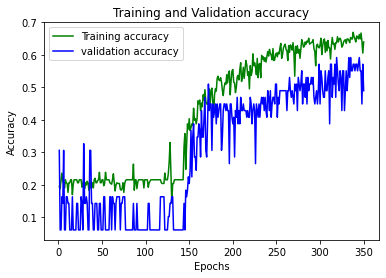

In [ ]:
history = network.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epocas, batch_size = 128)
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,epocas+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Ahora, obtenemos el **accuracy** y **loss** de la red.

In [ ]:
test_loss, test_acc = network.evaluate(X_test, y_test)
print('test_acc:', test_acc)

2/2 [==============================] - 0s 7ms/step - loss: 1.0454 - accuracy: 0.4898
test_acc: 0.4897959232330322


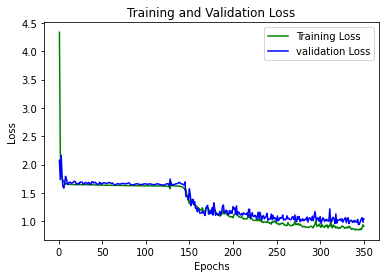

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,epocas+1)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Resumen del modelo**

In [ ]:
network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 290)               29000     
                                                                 
 dense_15 (Dense)            (None, 230)               66930     
                                                                 
 dense_16 (Dense)            (None, 100)               23100     
                                                                 
 dense_17 (Dense)            (None, 95)                9595      
                                                                 
 dense_18 (Dense)            (None, 5)                 480       
                                                                 
Total params: 129,105
Trainable params: 129,105
Non-trainable params: 0
_________________________________________________________________


Procedemos ahora a introducir una nota de voz y **predecir** utilizando este modelo, qué vocal es:


**NOTA:** la ruta del archivo es solo /content/Test, así que simplemente se añade el archivo (en formato .wav) para que el sistema lo utilice.

In [ ]:
def get_audio(name, path = "/content/Test"):
    path_test = path + "/"
    dir_path_Test = os.path.dirname(os.path.realpath(path_test))
    Test_records = []
    for root, dirs, files in os.walk(dir_path_Test):
        for record in files:
            name_ = name + ".wav"
            if record == name_:
                Test_records.append(record)
    try:
        if Test_records[-1] == Test_records[-2]:
            Test_records = Test_records[:-1]
    except:
        print(Test_records)
    #print(Test_records)
    return Test_records

Ahora, realizamos el mismo **preprocesamiento** que realizamos para los datos de **entrenamiento** (de la red) para la nota de voz de **entrada**. Así que, el orden sería el siguiente:


*   **Centrar**, **normalizar** y **recortar** la señal ingresada.
*   Obtener el **Power Spectral Density** de la **señal filtrada** en función de la **frecuencia**.
*   **Dividir** el dominio de **frecuencia** en **subintervalos**.
*   Calcular la **integral definida** bajo la **curva de densidad** para cada **subintervalo de frecuencia**.
*   Construir el **vector de integrales** definidas
*   Ingresar el **vector** de integrales como **entrada** a la red.







Definimos una función ***preprocessing(...)*** que recibe el nombre de un archivo **.wav** y la ruta al archivo, y luego realiza el mismo preprocesamiento que se realizó para cada una de las filas del dataset de entrenamiento de la red.

In [ ]:
def preprocessing(Test_records, path_test = "/content/Test"):
    for test in Test_records:
        visualize_wav_info(path_test, test)
    for test in Test_records:
        try:
            print(test)
            samplerate, data = wavfile.read(path_test+'/'+test)
            filter_data = remove_silences_signal(samplerate, data)
            norm_data = normalize_signal(samplerate, filter_data)
            cut_data = cut_signal(samplerate, norm_data)
            print(cut_data)
            visualize_wave(samplerate, cut_data)
        except Exception as exc:
            print(exc)
            traceback.print_exc()
        print()
    integrales_definidas_Test = []
    for test in Test_records:
        try:
            samplerate, data = wavfile.read(path_test+'/'+test)
            filter_data = remove_silences_signal(samplerate, data)
            norm_data = normalize_signal(samplerate, filter_data)
            cut_data = cut_signal(samplerate, norm_data)
            frecs, dens = get_psd(samplerate, norm_data)
            sub_intervals = divide_subintervals(dens, frecs, frec_limits)

            integrales_definidas = []
            inter = []
            for sub_int in sub_intervals:
                integrales_definidas.append(sum(sub_int))
            integrales_definidas_Test.append(integrales_definidas)
        except Exception as exc:
            print(exc)
            traceback.print_exc()
        plt.title('Test')
        plt.xlabel('frequency interval')
        plt.ylabel('density definite integral')
        for int_test in integrales_definidas_Test:
            plt.plot(int_test)
        plt.show()
    dataset_test = pd.DataFrame(integrales_definidas_Test)
    return dataset_test

Definimos una función ***predict(...)***, la cual predice la vocal pronunciada en base al vector de integrales definidas como: la vocal que tuvo mayor probabilidad de entre las 5, mediante el método ***network.predict(...)***.

In [ ]:
def predict(dataset):
    clases = {0:'A', 1:'E', 2:'I', 3:'O', 4:'U'}
    x = dataset_test
    y_proba = network.predict(x)
    y_proba

    y_proba = y_proba[0]
    print(y_proba)
    for i in range(y_proba.size):
        if y_proba[i] == max(y_proba):
            ind = i

    print("La vocal introducida es: '", clases[ind], "'")

In [74]:
def ogg_to_wav(name, path = "/content/Test/"):
    route = path+name
    audio_seg = AudioSegment.from_ogg(route+'.ogg')
    new_path = route+'.wav'
    audio_seg.export(new_path, format="wav")

A continuación, se introduce solo el nombre del archivo que se añadió a la carpeta Test y se realiza el **preprocesamiento**, y luego la **predicción** de la vocal.

**Preprocesamiento de la entrada**

Si el audio se encuentra en formato .ogg, correr esta línea de código, en caso contrario comentarla.

In [82]:
ogg_to_wav("ValTest") # .ogg a .wav

['ValTest.wav']
number of frames = 77760
number of channels = 1


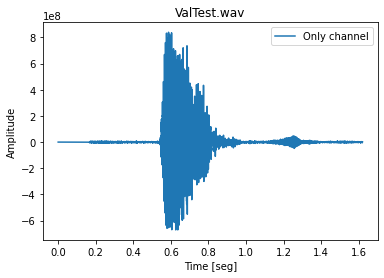

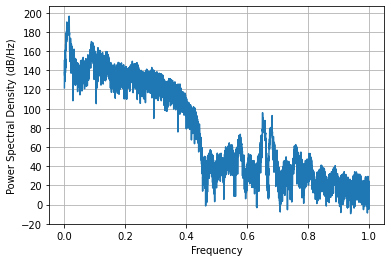

Duración:  1.62
ValTest.wav
[0.20414315290034454, 0.20970338141891406, 0.2095965045512861, 0.20512159584567805, 0.1979546867086726, 0.18927998427446566, 0.17945480622771032, 0.16828084401830287, 0.15553353228138084, 0.14140494428859743, 0.12669841081510572, 0.11274741384937909, 0.101187121795801, 0.093617245871359, 0.09110588736778921, 0.09370629403760745, 0.10026495843562432, 0.10873542213135431, 0.1170130021599138, 0.1238518345893415, 0.12918671594972594, 0.13359666907111017, 0.13733983829496557, 0.13977881417774754, 0.13973208772562937, 0.13638811933357153, 0.12981811893237807, 0.12061455238361347, 0.10910197832490408, 0.09497370495626266, 0.07787146595357772, 0.058402423939470656, 0.03847415462090003, 0.02056150579986724, 0.0065180236374925045, -0.003158359833505099, -0.009046654333829333, -0.011895938234027657, -0.012035314345413604, -0.009486504843123826, -0.004463939189264689, 0.002250125699733626, 0.009394075616680481, 0.015648749930353655, 0.020000602460183457, 0.0219008798404

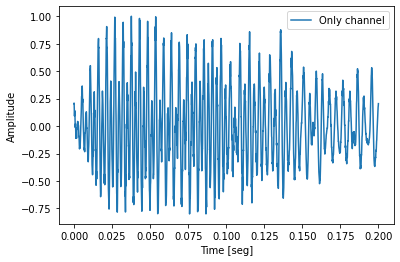

Duración:  0.20002083333333334 seg



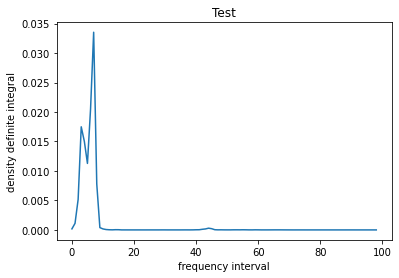

         0         1         2         3         4         5         6   \
0  0.000178  0.001113  0.005167  0.017489  0.015016  0.011278  0.020498   

         7         8         9   ...        89        90            91  \
0  0.033528  0.007792  0.000393  ...  0.000002  0.000001  4.763152e-07   

             92            93            94            95            96  \
0  4.789736e-07  4.872071e-07  3.784268e-07  3.423320e-07  3.632748e-07   

             97            98  
0  3.692673e-07  2.856950e-07  

[1 rows x 99 columns]


In [83]:
testing = get_audio("ValTest")
dataset_test = preprocessing(testing)
print(dataset_test)

**Predicción de la entrada**

In [84]:
predict(dataset_test)

[0.01035899 0.341899   0.9817283  0.47733566 0.94323426]
La vocal introducida es: ' I '


# Respuesta a las preguntas
* ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
>Debido al uso de secciones aleatorias dentro de los datos utilizados para las pruebas y validaciones, el comportamiento de la precisión de la red era inconsistente. Sin embargo, las ejecuciones de mejor calidad arrojaban una buena predicción de la vocal.
* ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
> Los intervalos en los cuales se dividen el total de los datos son los que definen inicialmente cuántas neuronas se disponen en la primera capa de la red. Con al menos el doble de neuronas.
De ahí, las siguientes capas fueron dispuestas con un número entre la primera capa y el número de intervalos.
Inicialmente se contemplaban dos capas, una por cada formante de una vocal, pero esto resultó siendo ineficiente y daba una precisión bastante baja, así que se añadieron capas hasta que el comportamiento fuera más estable.
* ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
> La red cuando está estable, tiene un comportamiento como el esperado, con las pérdidas descendiendo a la par. Esto se debe principalmente al uso de regularizadores en las últimas capas de la red, que redujeron al mínimo el overfitting que se presentaba en las últimas épocas.
* ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?
> Respecto al error que se genera debido a la división de los datos, sería delimitar el corte para que no sea tan errático entre iteraciones. Mientras que respecto al diseño de la red, con una cota de 0.7 de precisión en casi todos los intentos, podría añadirse una mayor variedad de datos para que la red pueda entender mejor el comportamiento de las clases de las señales, así como podría también alargar el tiempo de aprendizaje, siguiendo con su tendencia a crecer en precisión.